# Multi Target Detection In Heavy Tailed Clutter

## Imports

In [10]:
import os
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset

### Wandb

In [11]:
os.environ["WANDB_NOTEBOOK_NAME"] = "Target_Detection.ipynb"
wandb.login(key="a0b9279da3b2e8d45e371d1539a1118e7b82d303")
wandb.init(project="Target_detection-Unet_DAFC_DACK_Diffusion", mode="online")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


IQ_unet/train_loss,█▃▂▁▁▁▁▁▁▁▁
IQ_unet/val_dice,▁▁▁▁▁▁▁▁▁▁▁
IQ_unet/val_f1,▁▁▁▁▁▁▁▁▁▁▁
IQ_unet/val_loss,█▃▂▂▂▂▂▁▁▁▁
IQ_unet/val_precision,▁▁▁▁▁▁▁▁▁▁▁
IQ_unet/val_recall,▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
IQ_unet/train_loss,0.06355
IQ_unet/val_dice,0.0
IQ_unet/val_f1,0.0
IQ_unet/val_loss,0.06312


### Train RD

## Dataset

### Explanation

#### Initialization

Input parameters:
* num_samples: Number of samples in the dataset.
* n_targets: Maximum number of targets per sample (default is 8).
* random_n_targets: If True, the number of targets per sample is random up to n_targets.
* nu: Parameter for the K-distributed clutter (shape parameter of the Gamma distribution).
* scnr: Signal-to-clutter-plus-noise ratio (SCNR) in dB for the targets.

Radar Parameters:
* N = 64: --------------------- Number of fast-time samples per pulse.
* K = 64: --------------------- Number of pulses per frame (slow-time samples).
* B = 50e6: ------------------- Chirp bandwidth (Hz).
* T0 = 1e-3: ------------------ Pulse repetition interval (PRI) in seconds.
* fc = 9.39e9: ---------------- Carrier frequency (Hz).
* c = 3e8: -------------------- Speed of light (m/s).
* CNR = 15: ------------------ Clutter-to-noise ratio in dB.
Range and Doppler Parameters:
* r_min, r_max = 0, 189: ------- Minimum and maximum range (meters).
* v_min, v_max = -7.8, 7.8: ---- Minimum and maximum Doppler velocities (m/s).
* vc_min, vc_max = -7.8, 7.8: -- Clutter velocity range (m/s).
* dr = 3: ---------------------- Range resolution (m).
* dv = 0.249: ----------------- Doppler resolution (m/s).

Range Bins: originaly 64

$$\mathbf{R} = \{ r_{\text{min}}, r_{\text{min}} + \Delta r, \dots, r_{\text{max}} \}$$

Doppler Bins: originaly 64

$$\mathbf{V} = \{ v_{\text{3min}}, v_{\text{min}} + \Delta v, \dots, v_{\text{max}} \}$$

Number of Range and Doppler Bins:
$$d_R = |\mathbf{R}|,\quad d_V = |\mathbf{V}|$$

Noise Power $\sigma^2$ :

$$\text{CNR}_{\text{linear}} = 10^{\frac{\text{CNR}_{\text{dB}}}{10}}$$

$$\sigma^2 = \frac{N}{2 \cdot \text{CNR}_{\text{linear}}}$$

Normalization Constant $\text{cn\_norm}$:

$$\text{cn\_norm} = \sqrt{N \cdot K \cdot \left( \frac{N}{2} + \sigma^2 \right)}$$

#### Generate target signal
1. Compute the range steering vector:
$$w_r = \frac{2 \pi \cdot 2 \cdot B \cdot \text{ranges}}{c \cdot N}$$

The range steering vector is then calculated as:

$$\text{range\_steering} = e^{-j \cdot w_r \cdot \text{arange}(N)}$$


2. Compute the velocity steering vector:
$$w_d = \frac{2 \pi \cdot T_0 \cdot 2 \cdot f_c \cdot \text{velocities}}{c}$$

The velocity steering vector is then calculated as:

$$\text{velocity\_steering} = e^{-j \cdot w_d \cdot \text{arange}(K)}$$

3. Combine the range and Doppler steering vectors:

$$ rd\_signal= range\_steering * velocity\_steering$$

Shape: $$Num\_targets \times N \times K$$

4. apply random phases for targets:

$$ rd\_signal = rd_signal * e^{j*phases}$$

5. prepare for scaling: Compute the norm of the signal for each target:

$$ S\_norm = ||rd_signal||$$

$$ sig\_amp = 10^{SCNR\_DB/20} \cdot \frac{cn\_norm}{S\_norm}$$

6. Scale and sum the signals for all targets into a single matrix:
$$
\text{rd\_signal} = \sum_{\text{targets}} \left( \text{sig\_amp} \cdot \text{rd\_signal} \right)
$$

7. The final output is a matrix:
$$
\text{rd\_signal} \in \mathbb{C}^{N \times K}
$$


#### Generate clutter

This function generates K-distributed SIRV (Spherically Invariant Random Vector) clutter using eigendecomposition.

The clutter velocity is sampled uniformly:
$$
\text{clutter\_vel} \sim U(\text{vc\_min}, \text{vc\_max})
$$

The Doppler shift of the clutter is computed as:
$$
f_d = \frac{2 \pi \cdot 2 \cdot f_c \cdot \text{clutter\_vel}}{c}
$$

The correlation matrix $ M $ is generated using:
$$
M_{p,q} = e^{\left(-2 \pi^2 \sigma_f^2 (p - q)^2 - j (p - q) f_d T_0 \right)}
$$
where $\sigma_f$ is a fixed parameter from the paper.

Complex Normal Samples


Generate complex normal samples $z$:
$$
z \sim \mathcal{CN}(0, \frac{1}{2})
$$
with shape $(K \times d_R)$.

Eigenvalue Decomposition:


Perform eigenvalue decomposition on  $M$:
$$
M = V \Lambda V^\dagger
$$

The square root of eigenvalues is computed:
$$
E = \text{diag}(\sqrt{\max(\lambda, 0)})
$$

The clutter time-domain weights are computed as:
$$
w_t = A z \quad \text{where } A = V E
$$

Texture Component:


The texture component $ s $ is sampled from a Gamma distribution:
$$
s \sim \text{Gamma}(\nu, \nu)
$$

Scale the clutter weights by the texture component:
$$
c_t = \sqrt{s} \cdot w_t
$$

Fast-Time × Slow-Time Representation:

The fast-time steering vector $c_{r\_steer}$ is computed as:
$$
c_{r\_steer} = \exp\left(-j \cdot 2 \pi \cdot \text{arange}(N) \cdot R \cdot \frac{2 B}{c \cdot N}\right)
$$

The final clutter matrix $C$ is obtained by:
$$
C = c_{r\_steer} \cdot c_t^T
$$


The function returns the clutter matrix $ C $:
$$
C \in \mathbb{C}^{N \times K}
$$


#### Generate frame and labels

This function generates a radar frame containing noise, clutter, and optionally targets, along with a label matrix identifying the target locations in the range-Doppler plane.

1. Generate Noise

   The noise matrix $ W $ is generated as:
   $$
   W \sim \mathcal{CN}\left(0, \frac{1}{2 \sigma^2}\right), \quad W \in \mathbb{C}^{N \times K}
   $$

2. Generate Clutter

   The clutter texture parameter $ \nu $ is sampled as:
   $$
   \nu \sim U(0.1, 1.5)
   $$  
   if $ \nu $ is not provided. Otherwise, it is set to the user-defined value.  
   The clutter matrix $ C $ is then generated using:
   $$
   C = \text{generate\_clutter}(\nu)
   $$

3. Initialize Target Signal and Label Matrices

   - Initialize the target signal matrix $ S $ with zeros:
     $$
     S = \mathbf{0}, \quad S \in \mathbb{C}^{N \times K}
     $$
   - Initialize the label matrix $ \text{rd\_label} $ with zeros:
     $$
     \text{rd\_label} = \mathbf{0}, \quad \text{rd\_label} \in \{0, 1\}^{d_R \times d_V}
     $$

4. Generate Targets (if applicable) 

   If targets are enabled, the following steps are performed:
   - Sample the number of targets $ n $:
     $$
     n \sim U(1, \text{n\_targets})
     $$  
     if $ \text{random\_n\_targets} $ is enabled. Otherwise, $ n $ is fixed to $ \text{n\_targets} $.
   - Sample the target ranges, velocities, phases, and SCNR values:
     $$
     \text{ranges} \sim U(r_\text{min}, r_\text{max})
     $$
     $$
     \text{velocities} \sim U(v_\text{min}, v_\text{max})
     $$
     $$
     \text{phases} \sim U(0, 2 \pi)
     $$
     $$
     \text{SCNR\_dBs} \sim U(-5, 10)
     $$  
     if $ \text{scnr} $ is not provided. Otherwise, SCNR is set to a constant value.

   - Generate the target signal matrix $ S $:
     $$
     S = \text{generate\_target\_signal}(\text{ranges}, \text{velocities}, \text{phases}, \text{SCNR\_dBs})
     $$

   - Populate the label matrix $ \text{rd\_label} $:  
     For each target, determine the nearest range bin $ r_\text{bin} $ and Doppler bin $ v_\text{bin} $:
     $$
     r_\text{bin} = \arg\min |R - r|, \quad v_\text{bin} = \arg\min |V - v|
     $$
     Set:
     $$
     \text{rd\_label}[r_\text{bin}, v_\text{bin}] = 1
     $$

5. Combine Signals

   The final radar frame $ X $ is the sum of the target signal, clutter, and noise:
   $$
   X = S + C + W
   $$

6. Return  

   The function returns:
   $$
   X \in \mathbb{C}^{N \times K}, \quad \text{rd\_label} \in \{0, 1\}^{d_R \times d_V}
   $$


### Code

In [12]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets: int = 8, random_n_targets=True, nu=None, scnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.scnr = scnr
        self.nu = torch.tensor([nu]) if nu is not None else None

        # Parameters
        self.N = 64  # Samples per pulse (fast-time)
        self.K = 64  # Pulses per frame (slow-time)
        self.B = 50e6  # Chirp bandwidth (Hz)
        self.T0 = 1e-3  # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8  # Speed of light (m/s)
        self.CNR = 15  # Clutter-to-noise ratio (dB)

        # Range and Doppler parameters
        self.r_min, self.r_max = 0, 189  # Range interval (m)
        self.v_min, self.v_max = -7.8, 7.8  # Doppler interval (m/s)
        self.vc_min, self.vc_max = -7.8, 7.8  # Clutter min/max velocity (m/s)
        self.dr = 3  # Range resolution (m)
        self.dv = 0.249  # Doppler resolution (m/s)

        # Calculate range and Doppler bins
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)  # Number of range bins
        self.dV = len(self.V)  # Number of Doppler bins

        # Noise power calculation
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10)) 
        self.cn_norm = torch.sqrt(torch.tensor(self.N * self.K * (self.N // 2 + self.sigma2)))

        # Precompute the range steering matrix for matched filtering.
        # This acts as the matched filter in the range dimension.
        # For a linear FM chirp, the matched filter corresponds to the conjugate of the transmitted signal.
        # Here, we assume a uniform linear frequency modulation and use a steering vector based on the range bins.
        # range_steering_full will have dimensions (dR x N).
        w_range = (2 * torch.pi * (2 * self.B) / (self.c * self.N)) * self.R.unsqueeze(-1) * torch.arange(self.N)
        # w_range: dR x N
        self.range_steering_full = torch.exp(-1j * w_range)

    def generate_target_signal(self, ranges, velocities, phases, SCNR_dBs):
        # Range steering vector
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N)))

        # Doppler steering vector
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K)))
        
        # Fast-time x Slow-time matrix
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)

        # Random phase for each target
        rd_signal = rd_signal * torch.exp(1j * phases)

        # Scaling SCNR for each target
        S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
        sig_amp = (10 ** (SCNR_dBs / 20)) * (self.cn_norm / S_norm)
        rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)

        return rd_signal

    def generate_clutter(self, nu):
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = (2 * torch.pi * (2 * self.fc * clutter_vel) / self.c) 
        sigma_f = 0.05  # From the referenced paper
        p, q = torch.meshgrid(torch.arange(self.N),
                              torch.arange(self.K), indexing='ij')
        M = torch.exp(-2 * torch.pi ** 2 * sigma_f ** 2 * (p - q) ** 2 - 1j * (p - q) * fd * self.T0)
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))

        e, V = torch.linalg.eigh(M)
        e_sqrt = torch.sqrt(torch.maximum(e.real, torch.tensor(0.0)))
        E = torch.diag(e_sqrt)
        A = V @ E.to(V.dtype)
        w_t = A @ z

        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast-time × slow-time representation
        c_r_steer = torch.exp(-1j * 2 * torch.pi * torch.outer(torch.arange(self.N), self.R) * (2 * self.B) / (self.c * self.N))
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        # Generate Noise
        W = (torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0 * self.sigma2)))

        # Generate Clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C = self.generate_clutter(nu)

        # Initialize target signal and label matrices
        S = torch.zeros_like(W)
        rd_label = torch.zeros(self.dR, self.dV)
        if self.with_targets:
            n = torch.randint(1, self.n_targets + 1, (1,)) if self.random_n_targets else self.n_targets
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
            S = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)

            # Create label matrix
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        return S, C, W, rd_label

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        S, C, W, rd_label = self.gen_frame_and_labels()
        X = S+C+W
        IQ_map = X
        X_range = self.range_steering_full.conj() @ X     
        S_range = self.range_steering_full.conj() @ S

        S_RD = torch.fft.fft(S_range, dim=1)
        S_RD = torch.fft.fftshift(S_RD, dim=1)
        S_RD_magnitude = S_RD#.abs()
        clean_RD_map = S_RD_magnitude.flip(dims=[1])

        X_RD = torch.fft.fft(X_range, dim=1)
        X_RD = torch.fft.fftshift(X_RD, dim=1)

        X_RD_magnitude = X_RD#.abs()
        RD_map = X_RD_magnitude.flip(dims=[1]) 
        return S, C, IQ_map, clean_RD_map, RD_map, rd_label

In [13]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets: int = 3, random_n_targets=False, nu=None, scnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.scnr = scnr
        # If nu is provided, fix it; otherwise clutter nu will be drawn uniformly in [0.1, 1.5]
        self.nu = torch.tensor([nu]) if nu is not None else None

        # Radar parameters
        self.N = 64       # fast–time samples per pulse
        self.K = 64       # slow–time pulses per frame
        self.B = 50e6     # Chirp bandwidth (Hz)
        self.T0 = 1e-3    # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8      # Speed of light (m/s)
        self.CNR = 15     # Clutter-to-noise ratio in dB

        # Range and Doppler settings
        self.r_min, self.r_max = 0, 189    # meters
        self.v_min, self.v_max = -7.8, 7.8   # m/s (for targets)
        self.vc_min, self.vc_max = -7.8, 7.8 # m/s (for clutter)
        self.dr = 3     # Range resolution in m
        self.dv = 0.249 # Doppler resolution in m/s

        # Range and Doppler bins (for label maps)
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)

        # Noise power calculation
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        self.cn_norm = torch.sqrt(torch.tensor(self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float))

        # Precompute the range steering matrix (matched filter in range)
        w_range = (2 * torch.pi * (2 * self.B) / (self.c * self.N)) * self.R.unsqueeze(-1) * torch.arange(self.N, dtype=torch.float)
        self.range_steering_full = torch.exp(-1j * w_range)

    def generate_target_signal(self, ranges, velocities, phases, SCNR_dBs):
        # Range steering vector (one per target)
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        # Doppler steering vector (one per target)
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        # Form the fast–time × slow–time target signature for each target
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)  # impart random phase per target

        # Scale the target signature to achieve the desired SCNR (in dB)
        S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
        sig_amp = (10 ** (SCNR_dBs / 20)) * (self.cn_norm / S_norm)
        rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
        return rd_signal

    def generate_clutter(self, nu):
        # Choose a clutter velocity uniformly within the allowed limits
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  # Correlation parameter (from the referenced paper)
        p, q = torch.meshgrid(torch.arange(self.N, dtype=torch.float),
                              torch.arange(self.K, dtype=torch.float), indexing='ij')
        M = torch.exp(-2 * torch.pi ** 2 * sigma_f ** 2 * (p - q) ** 2 - 1j * (p - q) * fd * self.T0)
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z

        # Impart heavy–tailed behavior via Gamma modulation (shape and scale = nu)
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast–time × slow–time representation using a range–steering operation.
        c_r_steer = torch.exp(-1j * 2 * torch.pi * torch.outer(torch.arange(self.N, dtype=torch.float), self.R) *
                                (2 * self.B) / (self.c * self.N))
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        # Generate noise (complex Gaussian)
        W = (torch.randn(self.N, self.K, dtype=torch.cfloat) / 
             torch.sqrt(torch.tensor(2.0 * self.sigma2)))
        # Generate clutter; if self.nu is not set, choose nu uniformly in [0.1, 1.5]
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C = self.generate_clutter(nu)

        # Initialize target signal and label map
        S = torch.zeros_like(W)
        rd_label = torch.zeros(self.dR, self.dV)
        if self.with_targets:
            # If not random, use fixed number of targets.
            n = torch.randint(1, self.n_targets + 1, (1,)).item() if self.random_n_targets else self.n_targets
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
            S = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            # For each target, mark the closest range and Doppler bin.
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1
        return S, C, W, rd_label

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        S, C, W, rd_label = self.gen_frame_and_labels()
        X = S + C + W
        IQ_map = X
        # Range matched filtering using the precomputed steering matrix.
        X_range = self.range_steering_full.conj() @ X     
        S_range = self.range_steering_full.conj() @ S

        # Apply an FFT along slow–time, fftshift and flip to obtain the range–Doppler (RD) map.
        S_RD = torch.fft.fft(S_range, dim=1)
        S_RD = torch.fft.fftshift(S_RD, dim=1)
        clean_RD_map = S_RD.flip(dims=[1])
        X_RD = torch.fft.fft(X_range, dim=1)
        X_RD = torch.fft.fftshift(X_RD, dim=1)
        RD_map = X_RD.flip(dims=[1])
        return S, C, IQ_map, clean_RD_map, RD_map, rd_label


In [14]:
# Create datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0)

val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True)
val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2,
                        pin_memory=torch.cuda.is_available(), persistent_workers=True)

IQ_map type: torch.ComplexFloatTensor
RD_map type: torch.ComplexFloatTensor
Slow time x Fast time map shape: torch.Size([64, 64])
Range-Doppler map shape: torch.Size([64, 64])
Label shape: torch.Size([64, 64])


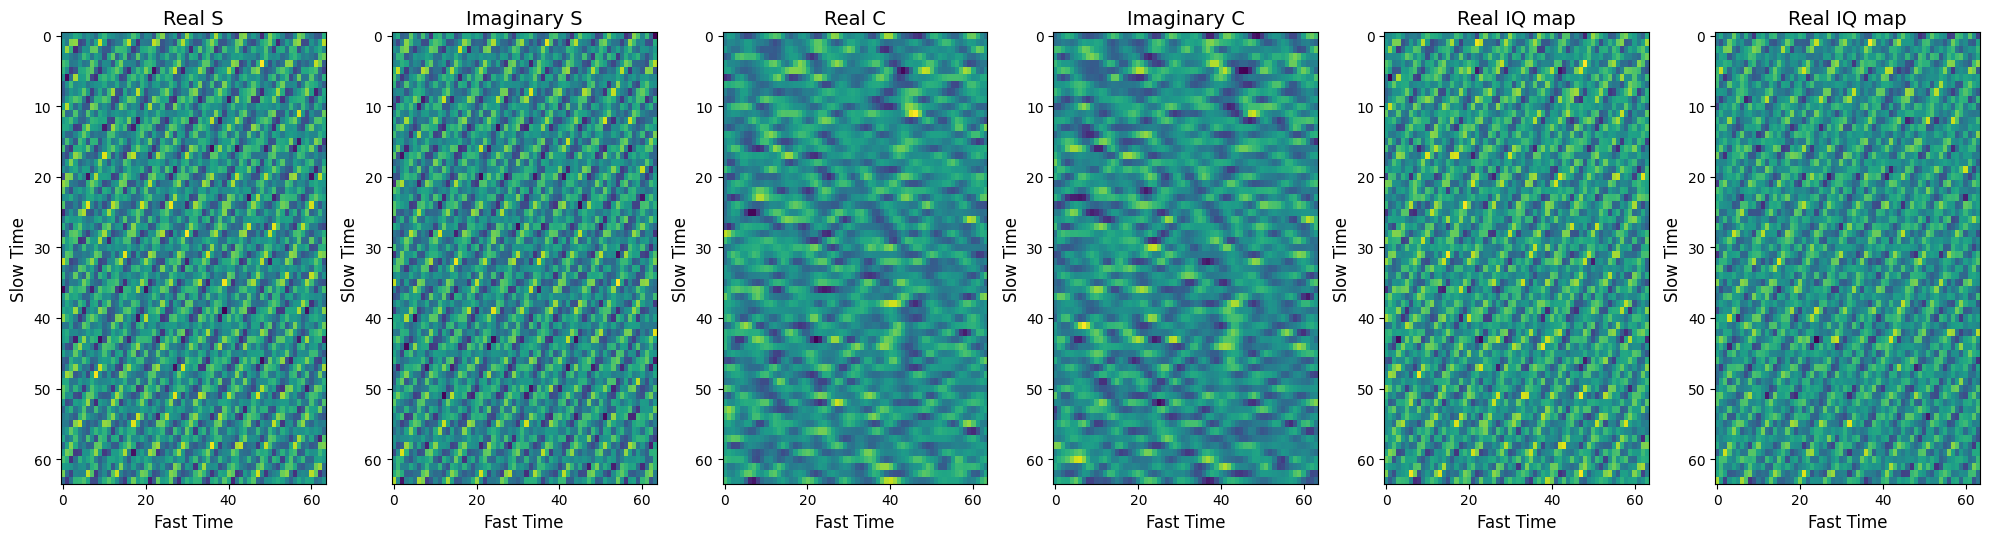

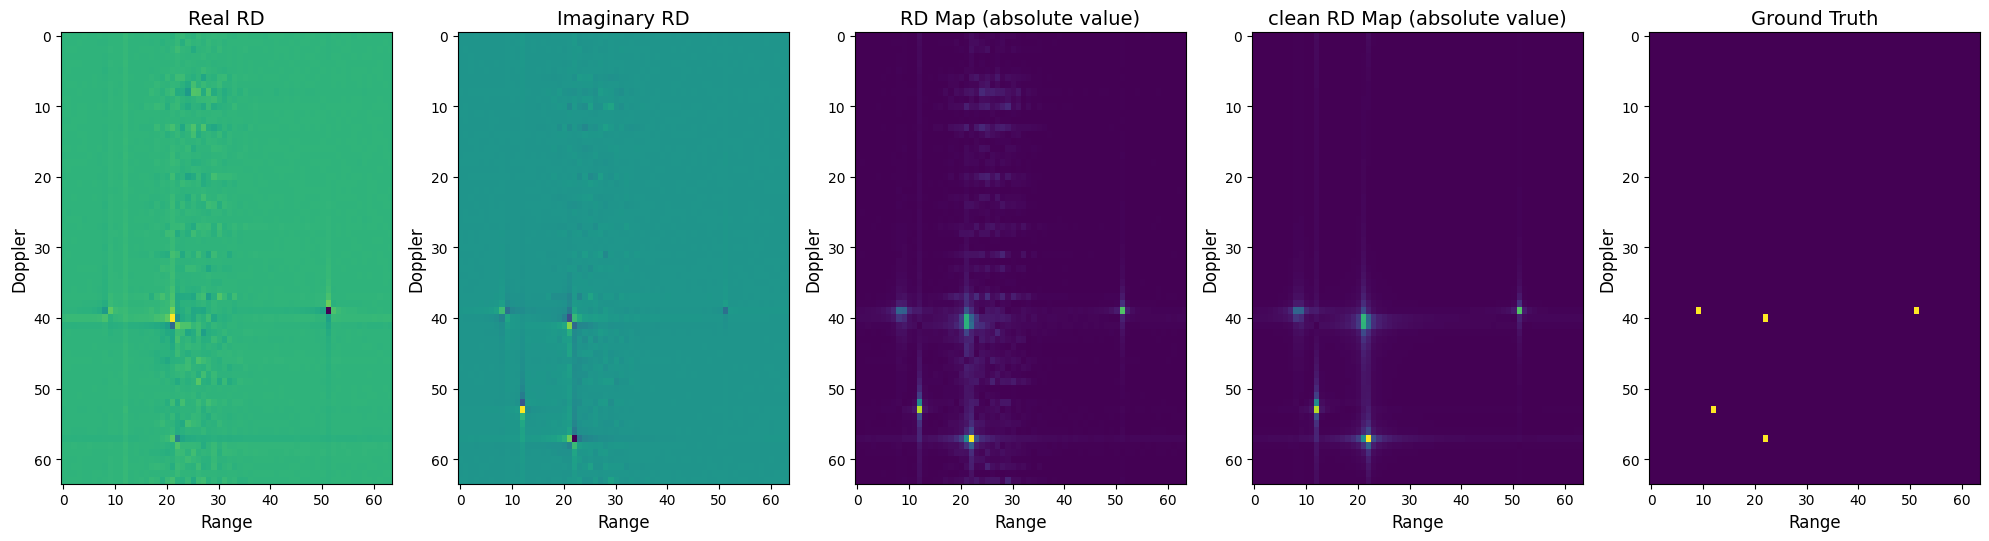

In [15]:
S, C, IQ_map, clean_RD_map, RD_map, RD_label = train_dataset_with_targets[1]

# Print some debug/reference information
print(f"IQ_map type: {IQ_map.type()}")
print(f"RD_map type: {RD_map.type()}")
print(f"Slow time x Fast time map shape: {IQ_map.shape}")
print(f"Range-Doppler map shape: {RD_map.shape}")
print(f"Label shape: {RD_label.shape}")

# Create a figure with five subplots in one row
plt.figure(figsize=(20, 6))

# Subplot 1: Real part of IQ data
plt.subplot(1, 6, 1)
plt.imshow(torch.real(S), aspect='auto', cmap='viridis')
plt.title("Real S", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Subplot 2: Imaginary part of IQ data
plt.subplot(1, 6, 2)
plt.imshow(torch.imag(S), aspect='auto', cmap='viridis')
plt.title("Imaginary S", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)
# Subplot 3: Magnitude of X_range
plt.subplot(1, 6, 3)
plt.imshow(torch.real(C) , aspect='auto', cmap='viridis')
plt.title("Real C", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Subplot 4: Magnitude of the Range-Doppler map
plt.subplot(1, 6, 4)
plt.imshow(torch.imag(C), aspect='auto', cmap='viridis')
plt.title("Imaginary C", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Subplot 5: Range-Doppler label (ground truth)
plt.subplot(1, 6, 5)
plt.imshow(torch.real(IQ_map), aspect='auto', cmap='viridis')
plt.title("Real IQ map", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

plt.subplot(1, 6, 6)
plt.imshow(torch.imag(IQ_map), aspect='auto', cmap='viridis')
plt.title("Real IQ map", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Adjust the layout, save, and show
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("maps")
plt.show()

plt.figure(figsize=(20, 6))

# Subplot 1: Real part of IQ data
plt.subplot(1, 5, 1)
plt.imshow(torch.real(RD_map), aspect='auto', cmap='viridis')
plt.title("Real RD", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

# Subplot 1: Real part of IQ data
plt.subplot(1, 5, 2)
plt.imshow(torch.imag(RD_map), aspect='auto', cmap='viridis')
plt.title("Imaginary RD", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

plt.subplot(1, 5, 3)
plt.imshow(torch.abs(RD_map), aspect='auto', cmap='viridis')
plt.title("RD Map (absolute value)", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

plt.subplot(1, 5, 4)
plt.imshow(torch.abs(clean_RD_map), aspect='auto', cmap='viridis')
plt.title("clean RD Map (absolute value)", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

# Subplot 2: Imaginary part of IQ data
plt.subplot(1, 5, 5)
plt.imshow(RD_label, aspect='auto', cmap='viridis')
plt.title("Ground Truth", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

# Adjust the layout, save, and show
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("maps")
plt.show()


## U-net

### Model definition

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        current_channels = in_channels
        for feature in features:
            self.downs.append(DoubleConv(current_channels, feature))
            current_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode="bilinear", align_corners=True)
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](x)

        return self.final_conv(x)  


### Custom loss

In [17]:
def calculate_ratio(train_loader, detection_type):
    """Calculate ratio of positive samples in dataset from 2D labels

    Args:
        train_loader: DataLoader for the training set
        detection_type: "range" or "doppler"
    
    Returns:
        ratio: The fraction of bins that contain targets
    """
    n1 = 0  # Count of bins with targets
    n_total = len(train_loader.dataset) * 64  # Adjust if your range-doppler map size is different

    for _, _, _, _, _, rd_label in train_loader:
        # rd_label is [B, dR, dV]
        # If detection_type == "range", sum over Doppler dimension (-1)
        # If detection_type == "doppler", sum over Range dimension (-2)
        
        if detection_type == "range":
            # Sum over Doppler dimension (last dimension)
            label = (rd_label.sum(dim=-1) >= 1).float()
        else:
            # Sum over Range dimension (second last dimension)
            label = (rd_label.sum(dim=-2) >= 1).float()

        # Count how many bins are positive
        n1 += torch.sum(label >= 0.9999)

    ratio = n1.item() / n_total
    print("ratio:", ratio, ", n1:", n1.item(), ", n_total:", n_total)
    return ratio


In [18]:
class CBBCE(nn.Module):
    def __init__(self, ratio: float, beta: float = 0.99):
        """
        Class-Balanced Binary Cross Entropy Loss for logits.
        
        Args:
            ratio: Ratio of positive samples (e.g., #positives / total_samples).
            beta: Beta parameter for class balancing.
        """
        super().__init__()
        self.weight1 = (1 - beta) / (1 - beta ** ratio)
        print("CBBCE weight for positives: ", self.weight1)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Args:
            y_pred: [B, N*K] logits
            y_true: [B, N*K] target (0 or 1)
        """
        # Compute element-wise BCE with logits
        _nll2 = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        
        # Identify positive samples
        # y_true is either 0 or 1. If exact 1 may be used:
        ind1 = (y_true >= 0.9999).nonzero(as_tuple=False)  # Indices of positives
        
        # Weight the positive samples
        if ind1.numel() > 0:
            _nll_subset = self.weight1 * _nll2[ind1[:, 0], ind1[:, 1]]
            _nll2 = _nll2.index_put_((ind1[:, 0], ind1[:, 1]), _nll_subset)
        
        # Mean loss
        loss = torch.mean(_nll2)
        return loss


### Train IQ

ratio: 0.03418121337890625 , n1: 44802 , n_total: 1310720
CBBCE weight for positives:  29.11431286990455
Epoch 1/200
Train Loss: 0.2501, Train Acc: 0.9784
Val Loss: 0.1375,   Val Acc: 0.9993
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 2/200
Train Loss: 0.1053, Train Acc: 0.9994
Val Loss: 0.0866,   Val Acc: 0.9995
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 3/200
Train Loss: 0.0820, Train Acc: 0.9994
Val Loss: 0.0778,   Val Acc: 0.9994
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 4/200
Train Loss: 0.0757, Train Acc: 0.9994
Val Loss: 0.0750,   Val Acc: 0.9994
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 5/200
Train Loss: 0.0734, Train Acc: 0.9994
Val Loss: 0.0723,   Val Acc: 0.9995
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 6/200
Train Loss: 0.0719, Train Acc: 0.9995
Val Loss: 0.0841,   Val Acc: 0.9995

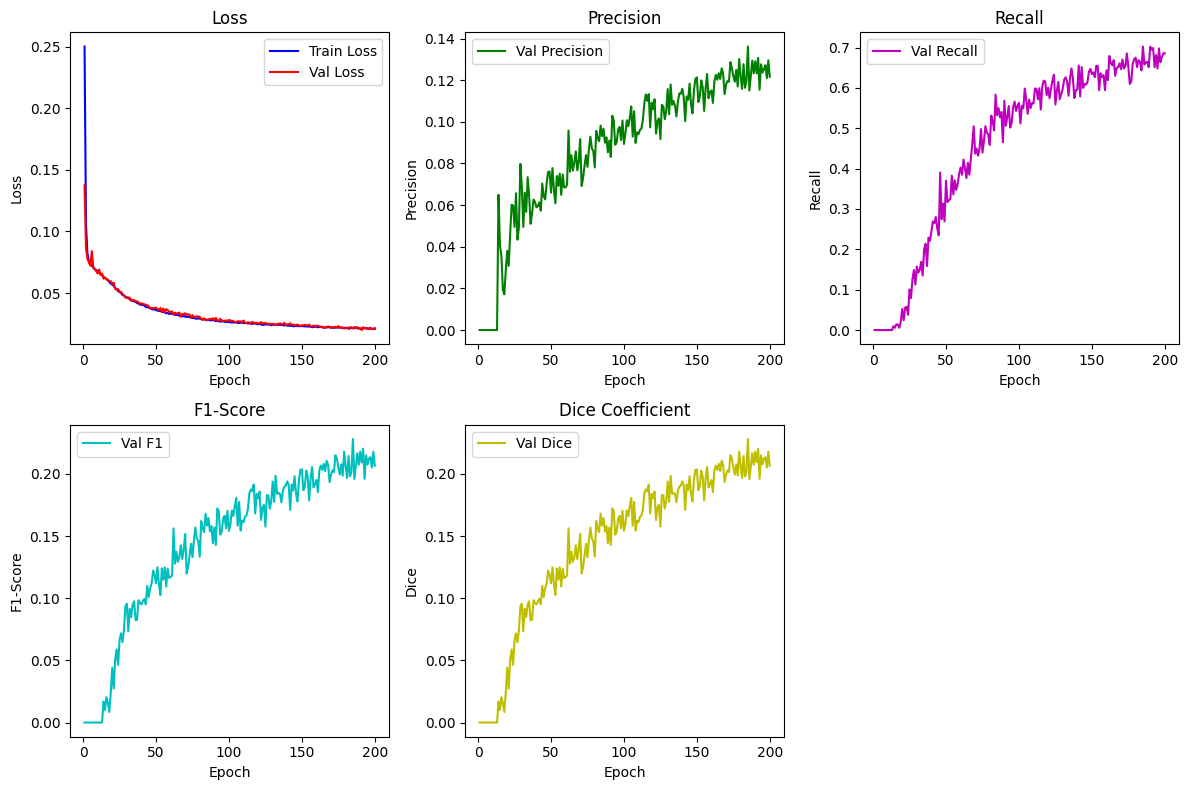

In [19]:
def compute_metrics(pred_mask, rd_label, eps=1e-8):
    pred_mask = pred_mask.bool()
    rd_label = rd_label.bool()

    tp = (pred_mask & rd_label).sum().item()
    fp = (pred_mask & ~rd_label).sum().item()
    fn = (~pred_mask & rd_label).sum().item()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * (precision * recall) / (precision + recall + eps)
    dice = (2 * tp) / (2*tp + fp + fn + eps)

    return precision, recall, f1, dice

# detection_type for ratio calculation
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)

model = UNet(in_channels=2, out_channels=1).cuda()
criterion = CBBCE(ratio=ratio)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)

# Early stopping parameters
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 200

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_precisions = []
val_recalls = []
val_f1s = []
val_dices = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        S, C, IQ_map, clean_RD_map, RD_map, rd_label = batch

        # Prepare inputs for IQ map
        IQ_map_real = IQ_map.real.unsqueeze(1).cuda()  # [B, 1, N, K]
        IQ_map_imag = IQ_map.imag.unsqueeze(1).cuda()
        IQ_map_input = torch.cat([IQ_map_real, IQ_map_imag], dim=1) # [B, 2, N, K]

        rd_label = rd_label.unsqueeze(1).float().cuda() # [B, 1, N, K]

        # Forward pass
        y_pred_logits = model(IQ_map_input)  # [B, 1, N, K] logits
        B, C, H, W = y_pred_logits.shape
        y_pred_flat = y_pred_logits.view(B, H*W)
        y_true_flat = rd_label.view(B, H*W)

        loss = criterion(y_pred_flat, y_true_flat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * B

        with torch.no_grad():
            pred_probs = torch.sigmoid(y_pred_logits)
            pred_mask = (pred_probs > 0.5).float()
            correct = (pred_mask == rd_label).sum().item()
            total = rd_label.numel()
            train_correct += correct
            train_total += total

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_tp, val_fp, val_fn = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            S, C, IQ_map, clean_RD_map, RD_map, rd_label = batch
            IQ_map_real = IQ_map.real.unsqueeze(1).cuda()
            IQ_map_imag = IQ_map.imag.unsqueeze(1).cuda()
            IQ_map_input = torch.cat([IQ_map_real, IQ_map_imag], dim=1)

            rd_label = rd_label.unsqueeze(1).float().cuda()

            y_pred_logits = model(IQ_map_input)
            B, C, H, W = y_pred_logits.shape
            y_pred_flat = y_pred_logits.view(B, H*W)
            y_true_flat = rd_label.view(B, H*W)

            loss = criterion(y_pred_flat, y_true_flat)
            val_loss += loss.item() * B

            pred_probs = torch.sigmoid(y_pred_logits)
            pred_mask = (pred_probs > 0.5).float()
            correct = (pred_mask == rd_label).sum().item()
            total = rd_label.numel()
            val_correct += correct
            val_total += total

            # Compute TP, FP, FN for val
            pred_bool = pred_mask.bool()
            gt_bool = rd_label.bool()
            val_tp += (pred_bool & gt_bool).sum().item()
            val_fp += (pred_bool & ~gt_bool).sum().item()
            val_fn += (~pred_bool & gt_bool).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_precision, val_recall, val_f1, val_dice = compute_metrics(pred_mask, rd_label)

    # Append metrics to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    val_dices.append(val_dice)

    wandb.log({
        "IQ_unet/train_loss": train_loss,
        "IQ_unet/val_loss": val_loss,
        "IQ_unet/val_precision": val_precision,
        "IQ_unet/val_recall": val_recall,
        "IQ_unet/val_f1": val_f1,
        "IQ_unet/val_dice": val_dice,
        "epoch": epoch + 1,
    })
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f},   Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}, Val Dice: {val_dice:.4f}")

    # Scheduler step - based on validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save best model so far
        torch.save(model.state_dict(), "IQ_unet.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation loss: ", best_val_loss)

# Plotting the metrics
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_precisions, 'g', label='Val Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, val_recalls, 'm', label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, val_f1s, 'c', label='Val F1')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, val_dices, 'y', label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout()
plt.show()


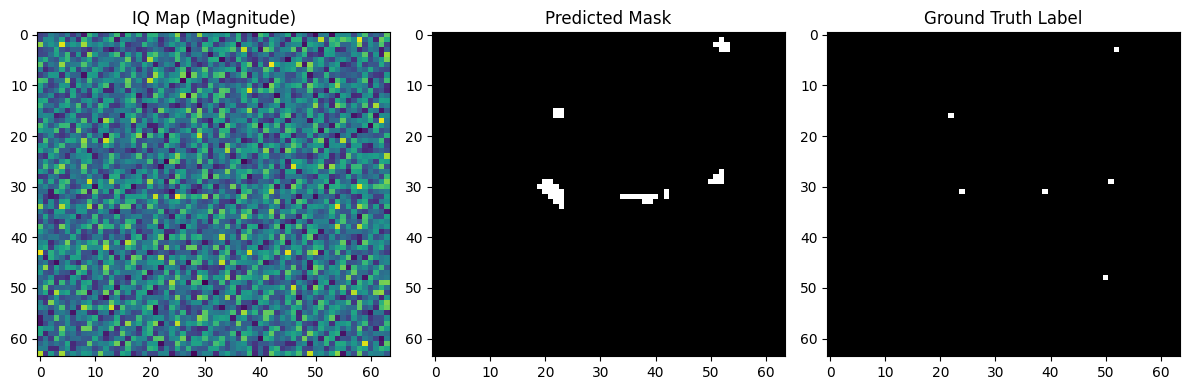

In [20]:
model.eval()
with torch.no_grad():
    S, C, IQ_map, clean_RD_map, RD_map, rd_label = train_dataset[0]

    IQ_map_real = IQ_map.real.unsqueeze(0).unsqueeze(1).cuda()
    IQ_map_imag = IQ_map.imag.unsqueeze(0).unsqueeze(1).cuda()
    IQ_map_input = torch.cat([IQ_map_real, IQ_map_imag], dim=1) # [1, 2, N, K]

    y_pred_logits = model(IQ_map_input)  # [1, 1, N, K]
    pred_probs = torch.sigmoid(y_pred_logits)  # Convert logits to probabilities
    pred_mask = (pred_probs > 0.5).float().cpu().squeeze(0).squeeze(0) # [N, K]

IQ_map_magnitude = IQ_map.abs()
rd_label_cpu = rd_label.cpu()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(IQ_map_magnitude, aspect='auto', cmap='viridis')
axs[0].set_title('IQ Map (Magnitude)')

axs[1].imshow(pred_mask, aspect='auto', cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Predicted Mask')

axs[2].imshow(rd_label_cpu, aspect='auto', cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Ground Truth Label')

plt.tight_layout()
plt.show()


ratio: 0.03384857177734375 , n1: 44366 , n_total: 1310720
CBBCE weight for positives:  29.400380132286458
Epoch 1/200
Train Loss: 0.1985, Train Acc: 0.9894
Val Loss: 0.0765,   Val Acc: 0.9996
Val Precision: 0.6075, Val Recall: 0.9844, Val F1: 0.7513, Val Dice: 0.7513
Epoch 2/200
Train Loss: 0.0435, Train Acc: 0.9997
Val Loss: 0.0265,   Val Acc: 0.9997
Val Precision: 0.6813, Val Recall: 0.9911, Val F1: 0.8075, Val Dice: 0.8075
Epoch 3/200
Train Loss: 0.0190, Train Acc: 0.9998
Val Loss: 0.0140,   Val Acc: 0.9998
Val Precision: 0.7183, Val Recall: 0.9903, Val F1: 0.8327, Val Dice: 0.8327
Epoch 4/200
Train Loss: 0.0108, Train Acc: 0.9998
Val Loss: 0.0085,   Val Acc: 0.9998
Val Precision: 0.7589, Val Recall: 0.9896, Val F1: 0.8591, Val Dice: 0.8591
Epoch 5/200
Train Loss: 0.0072, Train Acc: 0.9998
Val Loss: 0.0059,   Val Acc: 0.9998
Val Precision: 0.7414, Val Recall: 0.9915, Val F1: 0.8484, Val Dice: 0.8484
Epoch 6/200
Train Loss: 0.0051, Train Acc: 0.9998
Val Loss: 0.0045,   Val Acc: 0.999

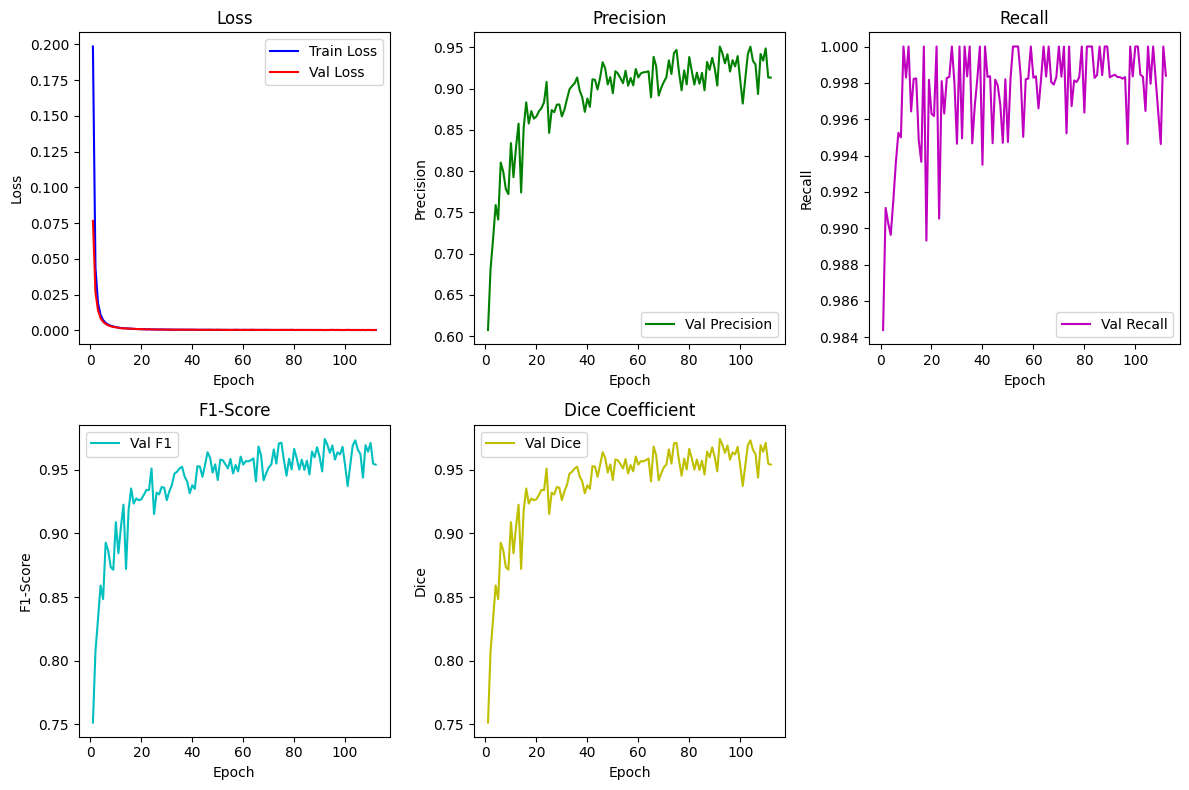

In [21]:
def compute_metrics(pred_mask, rd_label, eps=1e-8):
    pred_mask = pred_mask.bool()
    rd_label = rd_label.bool()

    tp = (pred_mask & rd_label).sum().item()
    fp = (pred_mask & ~rd_label).sum().item()
    fn = (~pred_mask & rd_label).sum().item()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * (precision * recall) / (precision + recall + eps)
    dice = (2 * tp) / (2*tp + fp + fn + eps)

    return precision, recall, f1, dice

# detection_type for ratio calculation
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)

model = UNet(in_channels=2, out_channels=1).cuda()
criterion = CBBCE(ratio=ratio)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)

# Early stopping parameters
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 200

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_precisions = []
val_recalls = []
val_f1s = []
val_dices = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        S, C, IQ_map, clean_RD_map, RD_map, rd_label = batch

        # Prepare inputs for IQ map
        RD_map_real = RD_map.real.unsqueeze(1).cuda()  # [B, 1, N, K]
        RD_map_imag = RD_map.imag.unsqueeze(1).cuda()
        RD_map_input = torch.cat([RD_map_real, RD_map_imag], dim=1) # [B, 2, N, K]

        rd_label = rd_label.unsqueeze(1).float().cuda() # [B, 1, N, K]

        # Forward pass
        y_pred_logits = model(RD_map_input)  # [B, 1, N, K] logits
        B, C, H, W = y_pred_logits.shape
        y_pred_flat = y_pred_logits.view(B, H*W)
        y_true_flat = rd_label.view(B, H*W)

        loss = criterion(y_pred_flat, y_true_flat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * B

        with torch.no_grad():
            pred_probs = torch.sigmoid(y_pred_logits)
            pred_mask = (pred_probs > 0.5).float()
            correct = (pred_mask == rd_label).sum().item()
            total = rd_label.numel()
            train_correct += correct
            train_total += total

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_tp, val_fp, val_fn = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            S, C, IQ_map, clean_RD_map, RD_map, rd_label = batch
            RD_map_real = RD_map.real.unsqueeze(1).cuda()
            RD_map_imag = RD_map.imag.unsqueeze(1).cuda()
            RD_map_input = torch.cat([RD_map_real, RD_map_imag], dim=1)

            rd_label = rd_label.unsqueeze(1).float().cuda()

            y_pred_logits = model(RD_map_input)
            B, C, H, W = y_pred_logits.shape
            y_pred_flat = y_pred_logits.view(B, H*W)
            y_true_flat = rd_label.view(B, H*W)

            loss = criterion(y_pred_flat, y_true_flat)
            val_loss += loss.item() * B

            pred_probs = torch.sigmoid(y_pred_logits)
            pred_mask = (pred_probs > 0.5).float()
            correct = (pred_mask == rd_label).sum().item()
            total = rd_label.numel()
            val_correct += correct
            val_total += total

            # Compute TP, FP, FN for val
            pred_bool = pred_mask.bool()
            gt_bool = rd_label.bool()
            val_tp += (pred_bool & gt_bool).sum().item()
            val_fp += (pred_bool & ~gt_bool).sum().item()
            val_fn += (~pred_bool & gt_bool).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_precision, val_recall, val_f1, val_dice = compute_metrics(pred_mask, rd_label)

    # Append metrics to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    val_dices.append(val_dice)

    wandb.log({
        "RD_unet/train_loss": train_loss,
        "RD_unet/val_loss": val_loss,
        "RD_unet/val_precision": val_precision,
        "RD_unet/val_recall": val_recall,
        "RD_unet/val_f1": val_f1,
        "RD_unet/val_dice": val_dice,
        "epoch": epoch + 1,
    })

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f},   Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}, Val Dice: {val_dice:.4f}")

    # Scheduler step - based on validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save best model so far
        torch.save(model.state_dict(), "RD_unet.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation loss: ", best_val_loss)

# Plotting the metrics
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_precisions, 'g', label='Val Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, val_recalls, 'm', label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, val_f1s, 'c', label='Val F1')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, val_dices, 'y', label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout()
plt.show()


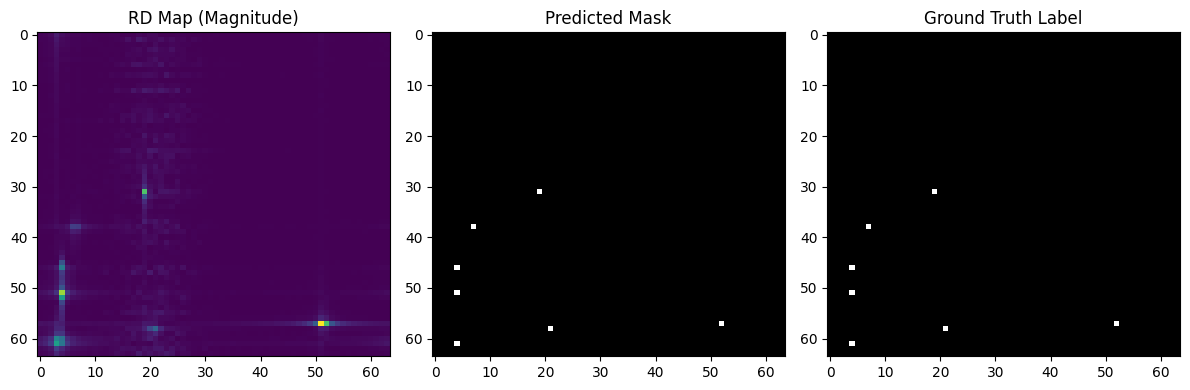

In [22]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    S, C, IQ_map, clean_RD_map, RD_map, rd_label = train_dataset[0]

    RD_map_real = RD_map.real.unsqueeze(0).unsqueeze(1).cuda()
    RD_map_imag = RD_map.imag.unsqueeze(0).unsqueeze(1).cuda()
    RD_map_input = torch.cat([RD_map_real, RD_map_imag], dim=1) # [1, 2, N, K]

    y_pred_logits = model(RD_map_input)  # [1, 1, N, K]
    pred_probs = torch.sigmoid(y_pred_logits)  # Convert logits to probabilities
    pred_mask = (pred_probs > 0.5).float().cpu().squeeze(0).squeeze(0) # [N, K]

RD_map_magnitude = RD_map.abs()
rd_label_cpu = rd_label.cpu()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(RD_map_magnitude, aspect='auto', cmap='viridis')
axs[0].set_title('RD Map (Magnitude)')

axs[1].imshow(pred_mask, aspect='auto', cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Predicted Mask')

axs[2].imshow(rd_label_cpu, aspect='auto', cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Ground Truth Label')

plt.tight_layout()
plt.show()


## DAFC-DACK

### Preprocessing

In [23]:
class RadarPreprocessing(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        Preprocessing module as described in Section III.B

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()
        self.detection_type = detection_type

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch, N, K, 2) - real and imaginary parts stacked in last dimension
        # Step 1: Reshape input based on detection type
        if self.detection_type == "range":
            X_0 = X.transpose(1, 2)  # (batch, K, N)
        else:  # doppler
            X_0 = X  # (batch, N, K)
        # Step 2: Center features over rows
        X_mean = torch.mean(X_0, dim=1, keepdim=True)
        X_1 = X_0 - X_mean
        # Step 3: Concatenate real and imaginary terms
        if torch.is_complex(X):

            Z_0 = torch.cat([X_1.real, X_1.imag], dim=-1)  # (batch, K/N, 2*N/K)
        else:
            Z_0 = torch.cat([X_1, torch.zeros_like(X_1)], dim=-1)
        return Z_0

### DAFC NN

In [24]:
class DAFCBlock(nn.Module):
    def __init__(self, H: int, W: int, H_out: int, W_out: int):
        """
        Dimensional-Alternating Fully Connected Block

        Args:
            H: Input height
            W: Input width
            H_out: Output height
            W_out: Output width
        """
        super().__init__()

        # Row mapping layer (F transform)
        self.row_fc = nn.Linear(W, W_out)

        # Column mapping layer (G transform)
        self.col_fc = nn.Linear(H, H_out)

        # Activation functions
        self.hr = nn.Tanh()
        self.hc = nn.Tanh()

    def forward(self, Z_in: torch.Tensor) -> torch.Tensor:
        Z_in = Z_in.float()
        batch_size = Z_in.size(0)
        H = Z_in.size(1)

        # Step 1: FC transform of each row
        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_in.reshape(-1, Z_in.size(-1))  # (batch*H, W)

        Z_r = self.hr(self.row_fc(Z_reshaped))  # (batch*H, W_out)

        # Reshaping back to normal after applying nn.Linear
        Z_r = Z_r.reshape(batch_size, H, -1)  # (batch, H, W_out)

        # Step 2: FC transform of each column
        Z_r = Z_r.transpose(1, 2)  # (batch, W_out, H)
        Z_r = Z_r.contiguous()  # Make memory contiguous after transpose

        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_r.reshape(-1, Z_r.size(-1))  # (batch*W_out, H)

        Z_out = self.hc(self.col_fc(Z_reshaped))  # (batch*W_out, H_out)

        # Reshaping back to normal after applying nn.Linear
        Z_out = Z_out.reshape(batch_size, -1, Z_out.size(-1))  # (batch, W_out, H_out)

        Z_out = Z_out.transpose(1, 2)  # (batch, H_out, W_out)

        return Z_out


class DAFCRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range", map_type: str = "IQ"):
        """
        DAFC-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        
        if map_type == "IQ":
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)
        else: # RD
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)

        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # DAFC blocks (dimensions from Table I)
        self.dafc1 = DAFCBlock(self.input_dim[0], self.input_dim[1], 128, 1024)
        self.dafc2 = DAFCBlock(128, 1024, 16, 256)
        self.dafc3 = DAFCBlock(16, 256, 4, 128)

        # Final FC layer
        fc_input_size = 4 * 128
        self.fc = nn.Linear(fc_input_size, 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)
        # DAFC blocks
        Z_1 = self.dafc1(Z_0)
        Z_2 = self.dafc2(Z_1)
        Z_3 = self.dafc3(Z_2)

        # Flatten and final FC layer
        Z_flat = Z_3.reshape(Z_3.size(0), -1)
        y = self.sigmoid(self.fc(Z_flat))

        return y
    


### DACK NN

In [25]:
class DACKRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range", map_type: str = "IQ"):
        """
        Convolution-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        if map_type == "IQ":
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)
        else: # RD
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)

        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  # Output: (16, 32, 64)

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  # Output: (32, 16, 32)

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  # Output: (64, 8, 16)

        # Fully connected layers
        if map_type == "IQ":
            fc_input_size = 64 * 8 * 16
        else:
            fc_input_size = 64 * 8 * 16 #8
        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)  # (batch, H, W)

        # Add channel dimension for convolutional layers
        Z_0 = Z_0.unsqueeze(1)  # (batch, 1, H, W)

        # Convolutional layers
        #print(Z_0.shape)
        Z_1 = self.conv1(Z_0)
        #print(Z_1.shape)
        Z_2 = self.conv2(Z_1)
        #print(Z_2.shape)
        Z_3 = self.conv3(Z_2)
        #print(Z_3.shape)

        # Flatten and fully connected layers
        Z_flat = Z_3.view(Z_3.size(0), -1)
        Z_fc1 = nn.ReLU()(self.fc1(Z_flat))
        y = self.sigmoid(self.fc2(Z_fc1))

        return y
        

### Custom Loss Function

In [26]:
class CBBCE(nn.Module):
    def __init__(self, ratio: float, beta: float = 0.99):
        """
        Class-Balanced Binary Cross Entropy Loss

        Args:
            ratio: Ratio of positive samples in dataset
            (number of targets in the dataset / number of bins in the dataset)
            beta: Beta parameter for class balancing
        """
        super().__init__()
        self.weight1 = (1 - beta) / (1 - beta ** ratio)
        print("w1: ", self.weight1)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            y_pred: Predicted values [batch, dim] (after sigmoid)
            y_true: True values [batch, dim]
        """
        _nll2 = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        # Find indices where y_true >= 0.9999
        ind1 = (y_true >= 0.9999).nonzero(as_tuple=False)  # Shape: [N, 2]

        # Gather the loss values at these indices
        _nll_subset = self.weight1 * _nll2[ind1[:, 0], ind1[:, 1]]

        # Update the original loss tensor using scatter_
        _nll2 = _nll2.index_put_((ind1[:, 0], ind1[:, 1]), _nll_subset)

        # Return the mean of the updated loss tensor
        loss = torch.mean(_nll2)
        return loss


In [32]:
def calculate_ratio(train_loader, detection_type):
    """Calculate ratio of positive samples in dataset from 2D labels"""
    n1 = 0  # target samples
    n_total = len(train_loader.dataset)
    n_total *= 32 if detection_type == 'range' else 63
    #for _, rd_label in train_loader:
    for _, _, _, _, _, rd_label in train_loader:
    
        # Get 1D labels by summing across appropriate dimension
        label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()
        # Count bins with targets
        n1 += torch.sum(label >= 0.9999)
    ratio = n1.item() / n_total
    print("ratio:", ratio, ", n1:", n1.item(), ", n_total:", n_total)
    return ratio


#### Plot function

In [33]:
def plot_training_history(history: dict, detection_type: str, map_type: str):
    """Plot and save training history for a given detector type.

    Parameters
    ----------
    history : dict
        A dictionary containing keys "train_loss", "val_loss", 
        "train_accuracy", and "val_accuracy", each mapping to a list 
        of values recorded per epoch.
    detection_type : str
        A string indicating the type/category of the detector 
        (e.g., 'Target', 'Object', 'Clutter').
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{detection_type} Detector Training History", fontsize=16, fontweight='bold')

    # Define a style
    #plt.style.use('seaborn')

    # Plot Loss
    ax1.plot(history["train_loss"], label="Training Loss", color="steelblue", linewidth=1)
    ax1.plot(history["val_loss"], label="Validation Loss", color="firebrick", linewidth=1)
    ax1.set_title("Loss per Epoch", fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history["train_accuracy"], label="Training Accuracy", color="darkgreen", linewidth=1)
    ax2.plot(history["val_accuracy"], label="Validation Accuracy", color="darkorange", linewidth=1)
    ax2.set_title("Accuracy per Epoch", fontsize=14)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    if map_type == "RD":
        plt.savefig(f"{detection_type}_RD_training_history.png", dpi=300)
    else:
        plt.savefig(f"{detection_type}_IQ_training_history.png", dpi=300)
    plt.close()


### Training

#### train function

In [34]:
def train_model(model, criterion, train_loader, val_loader, detection_type, map_type, epochs=300, learning_rate=1e-3,
                weight_decay=5e-4):
    """
    Train range or Doppler detector

    Args:
        model: Neural network model
        criterion: Loss function
        train_loader: Training data loader
        val_loader: Validation data loader
        detection_type: "range" or "doppler"
        map_type: "IQ" or "RD"
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for optimizer
    """

    # Initialize wandb
    wandb.init(
        project="radar_detection",  # replace with your project name
        name=f"{detection_type}_{map_type}_run",
        config={
            "detection_type": detection_type,
            "map_type": map_type,
            "epochs": epochs,
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "optimizer": "Adam"
        },
        tags=[detection_type, map_type]
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to device
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)
    # Check the last computed learning rate
    print(f"Last computed LR: {scheduler.get_last_lr()[0]}")

    # Training history
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None
    epoch_pbar = tqdm(range(epochs), desc="Training Progress")

    if map_type == "IQ":
        print('Training IQ network')
        for epoch in epoch_pbar:
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for _, _, X, _, _, rd_label in train_loader:
                X = X.to(device)
                rd_label = rd_label.to(device)

                # Preprocess input and get 1D label
                label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                # Forward pass
                outputs = model(X)
                loss = criterion(outputs, label)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                predictions = (outputs > 0.5).float()
                train_correct += (predictions == label).float().sum().item()
                train_total += label.numel()

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for _, _, X, _, _, rd_label in val_loader:
                    X = X.to(device)
                    rd_label = rd_label.to(device)

                    # Preprocess input and get 1D label
                    label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                    outputs = model(X)
                    loss = criterion(outputs, label)

                    val_loss += loss.item()
                    predictions = (outputs > 0.5).float()
                    val_correct += (predictions == label).float().sum().item()
                    val_total += label.numel()

            # Calculate epoch metrics
            epoch_train_loss = train_loss / len(train_loader)
            epoch_val_loss = val_loss / len(val_loader)
            epoch_train_acc = train_correct / train_total
            epoch_val_acc = val_correct / val_total

            # Update history
            history["train_loss"].append(epoch_train_loss)
            history["val_loss"].append(epoch_val_loss)
            history["train_accuracy"].append(epoch_train_acc)
            history["val_accuracy"].append(epoch_val_acc)

            # Log metrics to wandb
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": epoch_train_loss,
                "val_loss": epoch_val_loss,
                "train_accuracy": epoch_train_acc,
                "val_accuracy": epoch_val_acc,
                "learning_rate": scheduler.optimizer.param_groups[0]["lr"]
            })

            # Learning rate scheduling
            scheduler.step(epoch_val_loss)

            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                    break

            # Print epoch results every 10 epochs
            if epoch % 10 == 0:
                print(f"\nEpoch {epoch + 1}/{epochs}")
                print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
                print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        # Restore best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        # Save model
        torch.save(model.state_dict(), f"{detection_type}_64_{map_type}_IQ_model.pt")

    else:
        print('Training RD network')
        for epoch in epoch_pbar:
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for _, _, _, _, X, rd_label in train_loader:
                X = X.to(device)
                rd_label = rd_label.to(device)

                # Preprocess input and get 1D label
                label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                outputs = model(X)
                loss = criterion(outputs, label)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                predictions = (outputs > 0.5).float()
                train_correct += (predictions == label).float().sum().item()
                train_total += label.numel()

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for _, _, _, _, X, rd_label in val_loader:
                    X = X.to(device)
                    rd_label = rd_label.to(device)

                    label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                    outputs = model(X)
                    loss = criterion(outputs, label)

                    val_loss += loss.item()
                    predictions = (outputs > 0.5).float()
                    val_correct += (predictions == label).float().sum().item()
                    val_total += label.numel()

            # Calculate epoch metrics
            epoch_train_loss = train_loss / len(train_loader)
            epoch_val_loss = val_loss / len(val_loader)
            epoch_train_acc = train_correct / train_total
            epoch_val_acc = val_correct / val_total

            history["train_loss"].append(epoch_train_loss)
            history["val_loss"].append(epoch_val_loss)
            history["train_accuracy"].append(epoch_train_acc)
            history["val_accuracy"].append(epoch_val_acc)

            # Log metrics to wandb
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": epoch_train_loss,
                "val_loss": epoch_val_loss,
                "train_accuracy": epoch_train_acc,
                "val_accuracy": epoch_val_acc,
                "learning_rate": scheduler.optimizer.param_groups[0]["lr"]
            })

            scheduler.step(epoch_val_loss)

            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                    break

            if epoch % 10 == 0:
                print(f"\nEpoch {epoch + 1}/{epochs}")
                print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
                print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        torch.save(model.state_dict(), f"{detection_type}_64_{map_type}_IQ_model.pt")


    # Finish the wandb run
    wandb.finish()

    return history


#### Train DAFC models

In [35]:
# Train IQ range detector
print("\nTraining IQ Range Detector:")
map_type = "IQ"
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
range_model = DAFCRadarNet(detection_type, map_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(range_history, "Range", map_type)


Training IQ Range Detector:
ratio: 0.0686798095703125 , n1: 45010 , n_total: 655360
w1:  14.492396957923885


IQ_unet/train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
IQ_unet/val_dice,▁▁▁▂▃▃▄▄▄▄▅▅▆▅▅▆▆▆▇▆▇▆▆▆▆▇▇▇▇▇▇▇███▇████
IQ_unet/val_f1,▁▁▁▂▃▃▄▄▄▄▅▅▆▅▅▆▆▆▇▆▇▆▆▆▆▇▇▇▇▇▇▇███▇████
IQ_unet/val_loss,██▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
IQ_unet/val_precision,▁▁▁▃▄▅▅▄▄▄▅▅▆▅▅▆▆▆▇▆▆▆▆▆▆▆▇▇▇▇▇▇███▇▇███
IQ_unet/val_recall,▁▁▁▁▂▂▃▃▄▅▄▅▅▆▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇██▇████████
RD_unet/train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RD_unet/val_dice,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇█▇██▇█▇▇████▇███▇
RD_unet/val_f1,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇█▇██▇█▇▇████▇███▇
RD_unet/val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RD_unet/val_precision,▁▃▅▄▆▆▆▆▇▆▇▇▇▇▇▇█▇▇▇▇▇▇█▇██▇█▇▇████▇███▇


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training IQ network


Training Progress:   0%|          | 1/300 [00:10<53:34, 10.75s/it]


Epoch 1/300
Train Loss: 0.8410 | Val Loss: 0.6754
Train Acc: 0.8765 | Val Acc: 0.7277


Training Progress:   4%|▎         | 11/300 [01:58<51:48, 10.76s/it]


Epoch 11/300
Train Loss: 0.6436 | Val Loss: 0.6477
Train Acc: 0.7377 | Val Acc: 0.7019


Training Progress:   7%|▋         | 21/300 [03:46<50:09, 10.79s/it]


Epoch 21/300
Train Loss: 0.5887 | Val Loss: 0.5787
Train Acc: 0.7566 | Val Acc: 0.7503


Training Progress:  10%|█         | 31/300 [05:34<48:25, 10.80s/it]


Epoch 31/300
Train Loss: 0.4609 | Val Loss: 0.4563
Train Acc: 0.8342 | Val Acc: 0.8314


Training Progress:  14%|█▎        | 41/300 [07:22<46:37, 10.80s/it]


Epoch 41/300
Train Loss: 0.3320 | Val Loss: 0.3275
Train Acc: 0.8917 | Val Acc: 0.8945


Training Progress:  17%|█▋        | 51/300 [09:10<44:48, 10.80s/it]


Epoch 51/300
Train Loss: 0.2653 | Val Loss: 0.2640
Train Acc: 0.9210 | Val Acc: 0.9173


Training Progress:  20%|██        | 61/300 [10:58<43:02, 10.81s/it]


Epoch 61/300
Train Loss: 0.2249 | Val Loss: 0.2262
Train Acc: 0.9370 | Val Acc: 0.9403


Training Progress:  24%|██▎       | 71/300 [12:45<41:09, 10.78s/it]


Epoch 71/300
Train Loss: 0.2033 | Val Loss: 0.2029
Train Acc: 0.9445 | Val Acc: 0.9434


Training Progress:  27%|██▋       | 81/300 [14:33<39:19, 10.77s/it]


Epoch 81/300
Train Loss: 0.1887 | Val Loss: 0.1894
Train Acc: 0.9499 | Val Acc: 0.9492


Training Progress:  30%|███       | 91/300 [16:21<37:34, 10.79s/it]


Epoch 91/300
Train Loss: 0.1823 | Val Loss: 0.1785
Train Acc: 0.9524 | Val Acc: 0.9562


Training Progress:  34%|███▎      | 101/300 [18:09<35:48, 10.79s/it]


Epoch 101/300
Train Loss: 0.1714 | Val Loss: 0.1704
Train Acc: 0.9562 | Val Acc: 0.9562


Training Progress:  37%|███▋      | 111/300 [19:57<33:59, 10.79s/it]


Epoch 111/300
Train Loss: 0.1666 | Val Loss: 0.1669
Train Acc: 0.9584 | Val Acc: 0.9575


Training Progress:  40%|████      | 121/300 [21:45<32:14, 10.81s/it]


Epoch 121/300
Train Loss: 0.1630 | Val Loss: 0.1638
Train Acc: 0.9595 | Val Acc: 0.9596


Training Progress:  44%|████▎     | 131/300 [23:33<30:19, 10.77s/it]


Epoch 131/300
Train Loss: 0.1573 | Val Loss: 0.1639
Train Acc: 0.9611 | Val Acc: 0.9614


Training Progress:  47%|████▋     | 141/300 [25:21<28:38, 10.81s/it]


Epoch 141/300
Train Loss: 0.1558 | Val Loss: 0.1543
Train Acc: 0.9618 | Val Acc: 0.9618


Training Progress:  50%|█████     | 151/300 [27:09<26:52, 10.82s/it]


Epoch 151/300
Train Loss: 0.1545 | Val Loss: 0.1562
Train Acc: 0.9620 | Val Acc: 0.9612


Training Progress:  54%|█████▎    | 161/300 [28:57<25:01, 10.80s/it]


Epoch 161/300
Train Loss: 0.1526 | Val Loss: 0.1534
Train Acc: 0.9627 | Val Acc: 0.9638


Training Progress:  57%|█████▋    | 171/300 [30:45<23:11, 10.78s/it]


Epoch 171/300
Train Loss: 0.1510 | Val Loss: 0.1509
Train Acc: 0.9635 | Val Acc: 0.9645


Training Progress:  60%|██████    | 181/300 [32:33<21:23, 10.78s/it]


Epoch 181/300
Train Loss: 0.1462 | Val Loss: 0.1499
Train Acc: 0.9645 | Val Acc: 0.9644


Training Progress:  64%|██████▎   | 191/300 [34:21<19:38, 10.81s/it]


Epoch 191/300
Train Loss: 0.1476 | Val Loss: 0.1438
Train Acc: 0.9642 | Val Acc: 0.9664


Training Progress:  67%|██████▋   | 201/300 [36:09<17:50, 10.82s/it]


Epoch 201/300
Train Loss: 0.1465 | Val Loss: 0.1433
Train Acc: 0.9647 | Val Acc: 0.9645


Training Progress:  70%|███████   | 211/300 [37:57<16:00, 10.79s/it]


Epoch 211/300
Train Loss: 0.1452 | Val Loss: 0.1418
Train Acc: 0.9651 | Val Acc: 0.9655


Training Progress:  74%|███████▎  | 221/300 [39:45<14:15, 10.82s/it]


Epoch 221/300
Train Loss: 0.1444 | Val Loss: 0.1416
Train Acc: 0.9651 | Val Acc: 0.9658


Training Progress:  75%|███████▍  | 224/300 [40:28<13:44, 10.84s/it]


Early stopping triggered after 225 epochs


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████████▇▇▇▆▆▆▆▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁
train_accuracy,▁▁▁▂▂▄▅▆▆▇▇▇▇▇██████████████████████████
train_loss,███▇▇▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▂▂▂▄▆▆▆▇▇▇▇▇██████████████████████████
val_loss,███▇▇▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,225
learning_rate,0.00025
train_accuracy,0.96516
train_loss,0.14473
val_accuracy,0.96427


In [36]:
print("\nTraining RD Range Detector:")
map_type = "RD"
detection_type = "range"
criterion = CBBCE(ratio)
range_model = DAFCRadarNet(detection_type, map_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(range_history, "Range", map_type)


Training RD Range Detector:
w1:  14.492396957923885


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training RD network


Training Progress:   0%|          | 1/300 [00:10<54:12, 10.88s/it]


Epoch 1/300
Train Loss: 0.9372 | Val Loss: 0.9375
Train Acc: 0.9567 | Val Acc: 0.9656


Training Progress:   4%|▎         | 11/300 [01:58<52:02, 10.80s/it]


Epoch 11/300
Train Loss: 0.2805 | Val Loss: 0.2789
Train Acc: 0.9465 | Val Acc: 0.9375


Training Progress:   7%|▋         | 21/300 [03:46<50:14, 10.80s/it]


Epoch 21/300
Train Loss: 0.1785 | Val Loss: 0.1800
Train Acc: 0.9687 | Val Acc: 0.9749


Training Progress:  10%|█         | 31/300 [05:34<48:26, 10.80s/it]


Epoch 31/300
Train Loss: 0.1540 | Val Loss: 0.1544
Train Acc: 0.9742 | Val Acc: 0.9779


Training Progress:  14%|█▎        | 41/300 [07:22<46:37, 10.80s/it]


Epoch 41/300
Train Loss: 0.1411 | Val Loss: 0.1414
Train Acc: 0.9768 | Val Acc: 0.9784


Training Progress:  17%|█▋        | 51/300 [09:11<44:55, 10.82s/it]


Epoch 51/300
Train Loss: 0.1325 | Val Loss: 0.1307
Train Acc: 0.9781 | Val Acc: 0.9764


Training Progress:  20%|██        | 61/300 [10:59<43:00, 10.80s/it]


Epoch 61/300
Train Loss: 0.1273 | Val Loss: 0.1235
Train Acc: 0.9788 | Val Acc: 0.9795


Training Progress:  24%|██▎       | 71/300 [12:47<41:12, 10.79s/it]


Epoch 71/300
Train Loss: 0.1226 | Val Loss: 0.1221
Train Acc: 0.9796 | Val Acc: 0.9801


Training Progress:  27%|██▋       | 81/300 [14:35<39:22, 10.79s/it]


Epoch 81/300
Train Loss: 0.1183 | Val Loss: 0.1182
Train Acc: 0.9802 | Val Acc: 0.9798


Training Progress:  30%|███       | 91/300 [16:23<37:38, 10.81s/it]


Epoch 91/300
Train Loss: 0.1141 | Val Loss: 0.1133
Train Acc: 0.9807 | Val Acc: 0.9787


Training Progress:  34%|███▎      | 101/300 [18:10<35:48, 10.79s/it]


Epoch 101/300
Train Loss: 0.1129 | Val Loss: 0.1148
Train Acc: 0.9807 | Val Acc: 0.9777


Training Progress:  37%|███▋      | 111/300 [19:59<34:06, 10.83s/it]


Epoch 111/300
Train Loss: 0.1078 | Val Loss: 0.1067
Train Acc: 0.9817 | Val Acc: 0.9824


Training Progress:  40%|████      | 121/300 [21:46<32:09, 10.78s/it]


Epoch 121/300
Train Loss: 0.1061 | Val Loss: 0.1046
Train Acc: 0.9819 | Val Acc: 0.9815


Training Progress:  44%|████▎     | 131/300 [23:35<30:26, 10.81s/it]


Epoch 131/300
Train Loss: 0.1043 | Val Loss: 0.1054
Train Acc: 0.9822 | Val Acc: 0.9802


Training Progress:  47%|████▋     | 141/300 [25:23<28:39, 10.81s/it]


Epoch 141/300
Train Loss: 0.1029 | Val Loss: 0.1037
Train Acc: 0.9826 | Val Acc: 0.9835


Training Progress:  50%|█████     | 151/300 [27:11<26:53, 10.83s/it]


Epoch 151/300
Train Loss: 0.1005 | Val Loss: 0.0985
Train Acc: 0.9830 | Val Acc: 0.9840


Training Progress:  54%|█████▎    | 161/300 [28:59<24:59, 10.79s/it]


Epoch 161/300
Train Loss: 0.0983 | Val Loss: 0.0996
Train Acc: 0.9837 | Val Acc: 0.9814


Training Progress:  57%|█████▋    | 171/300 [30:47<23:10, 10.78s/it]


Epoch 171/300
Train Loss: 0.0958 | Val Loss: 0.0979
Train Acc: 0.9838 | Val Acc: 0.9856


Training Progress:  60%|██████    | 181/300 [32:35<21:22, 10.78s/it]


Epoch 181/300
Train Loss: 0.0947 | Val Loss: 0.0936
Train Acc: 0.9841 | Val Acc: 0.9853


Training Progress:  64%|██████▎   | 191/300 [34:22<19:35, 10.78s/it]


Epoch 191/300
Train Loss: 0.0932 | Val Loss: 0.0925
Train Acc: 0.9845 | Val Acc: 0.9862


Training Progress:  67%|██████▋   | 201/300 [36:10<17:46, 10.78s/it]


Epoch 201/300
Train Loss: 0.0905 | Val Loss: 0.0915
Train Acc: 0.9850 | Val Acc: 0.9855


Training Progress:  70%|███████   | 211/300 [37:58<15:58, 10.77s/it]


Epoch 211/300
Train Loss: 0.0894 | Val Loss: 0.0871
Train Acc: 0.9852 | Val Acc: 0.9852


Training Progress:  74%|███████▎  | 221/300 [39:46<14:13, 10.80s/it]


Epoch 221/300
Train Loss: 0.0857 | Val Loss: 0.0884
Train Acc: 0.9858 | Val Acc: 0.9853


Training Progress:  77%|███████▋  | 231/300 [41:34<12:26, 10.82s/it]


Epoch 231/300
Train Loss: 0.0857 | Val Loss: 0.0847
Train Acc: 0.9859 | Val Acc: 0.9842


Training Progress:  80%|████████  | 241/300 [43:22<10:37, 10.81s/it]


Epoch 241/300
Train Loss: 0.0847 | Val Loss: 0.0851
Train Acc: 0.9861 | Val Acc: 0.9838


Training Progress:  84%|████████▎ | 251/300 [45:11<08:48, 10.79s/it]


Epoch 251/300
Train Loss: 0.0853 | Val Loss: 0.0839
Train Acc: 0.9860 | Val Acc: 0.9868


Training Progress:  87%|████████▋ | 261/300 [46:58<07:00, 10.78s/it]


Epoch 261/300
Train Loss: 0.0827 | Val Loss: 0.0808
Train Acc: 0.9863 | Val Acc: 0.9872


Training Progress:  90%|█████████ | 271/300 [48:46<05:12, 10.79s/it]


Epoch 271/300
Train Loss: 0.0810 | Val Loss: 0.0818
Train Acc: 0.9867 | Val Acc: 0.9867


Training Progress:  94%|█████████▎| 281/300 [50:35<03:25, 10.81s/it]


Epoch 281/300
Train Loss: 0.0811 | Val Loss: 0.0795
Train Acc: 0.9867 | Val Acc: 0.9860


Training Progress:  97%|█████████▋| 291/300 [52:22<01:37, 10.80s/it]


Epoch 291/300
Train Loss: 0.0807 | Val Loss: 0.0811
Train Acc: 0.9870 | Val Acc: 0.9861


Training Progress: 100%|██████████| 300/300 [54:00<00:00, 10.80s/it]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,████████▇▇▇▇▇▇▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
train_accuracy,▁▆▇█████████████████████████████████████
train_loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇█████████████████████████████████████
val_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,300
learning_rate,0.0001
train_accuracy,0.98706
train_loss,0.08015
val_accuracy,0.98704


In [37]:
# Train IQ Doppler detector
map_type = "IQ"
detection_type = "doppler"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
print("\nTraining IQ Doppler Detector:")
doppler_model = DAFCRadarNet(detection_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(doppler_history, "Doppler", map_type)

ratio: 0.034496682787698414 , n1: 44509 , n_total: 1290240
w1:  28.848110533976634

Training IQ Doppler Detector:


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training IQ network


Training Progress:   0%|          | 1/300 [00:10<53:50, 10.80s/it]


Epoch 1/300
Train Loss: 1.2159 | Val Loss: 0.9420
Train Acc: 0.5866 | Val Acc: 0.6406


Training Progress:   4%|▎         | 11/300 [01:58<52:01, 10.80s/it]


Epoch 11/300
Train Loss: 0.5491 | Val Loss: 0.4847
Train Acc: 0.8253 | Val Acc: 0.8598


Training Progress:   7%|▋         | 21/300 [03:46<50:12, 10.80s/it]


Epoch 21/300
Train Loss: 0.2063 | Val Loss: 0.2034
Train Acc: 0.9490 | Val Acc: 0.9557


Training Progress:  10%|█         | 31/300 [05:34<48:20, 10.78s/it]


Epoch 31/300
Train Loss: 0.1417 | Val Loss: 0.1432
Train Acc: 0.9688 | Val Acc: 0.9707


Training Progress:  14%|█▎        | 41/300 [07:22<46:39, 10.81s/it]


Epoch 41/300
Train Loss: 0.1173 | Val Loss: 0.1190
Train Acc: 0.9766 | Val Acc: 0.9711


Training Progress:  17%|█▋        | 51/300 [09:10<44:46, 10.79s/it]


Epoch 51/300
Train Loss: 0.1059 | Val Loss: 0.1067
Train Acc: 0.9805 | Val Acc: 0.9785


Training Progress:  20%|██        | 61/300 [10:58<43:05, 10.82s/it]


Epoch 61/300
Train Loss: 0.1018 | Val Loss: 0.0968
Train Acc: 0.9821 | Val Acc: 0.9804


Training Progress:  24%|██▎       | 71/300 [12:46<41:14, 10.80s/it]


Epoch 71/300
Train Loss: 0.0968 | Val Loss: 0.1047
Train Acc: 0.9835 | Val Acc: 0.9835


Training Progress:  27%|██▋       | 81/300 [14:34<39:25, 10.80s/it]


Epoch 81/300
Train Loss: 0.0894 | Val Loss: 0.0889
Train Acc: 0.9850 | Val Acc: 0.9882


Training Progress:  30%|███       | 91/300 [16:22<37:33, 10.78s/it]


Epoch 91/300
Train Loss: 0.0876 | Val Loss: 0.0794
Train Acc: 0.9861 | Val Acc: 0.9875


Training Progress:  34%|███▎      | 101/300 [18:10<35:48, 10.80s/it]


Epoch 101/300
Train Loss: 0.0800 | Val Loss: 0.0808
Train Acc: 0.9876 | Val Acc: 0.9891


Training Progress:  37%|███▋      | 111/300 [19:58<34:03, 10.81s/it]


Epoch 111/300
Train Loss: 0.0798 | Val Loss: 0.0804
Train Acc: 0.9877 | Val Acc: 0.9862


Training Progress:  40%|████      | 121/300 [21:46<32:13, 10.80s/it]


Epoch 121/300
Train Loss: 0.0737 | Val Loss: 0.0782
Train Acc: 0.9889 | Val Acc: 0.9881


Training Progress:  44%|████▎     | 131/300 [23:34<30:26, 10.80s/it]


Epoch 131/300
Train Loss: 0.0737 | Val Loss: 0.0742
Train Acc: 0.9891 | Val Acc: 0.9906


Training Progress:  47%|████▋     | 141/300 [25:22<28:37, 10.80s/it]


Epoch 141/300
Train Loss: 0.0712 | Val Loss: 0.0739
Train Acc: 0.9897 | Val Acc: 0.9903


Training Progress:  50%|█████     | 151/300 [27:10<26:48, 10.79s/it]


Epoch 151/300
Train Loss: 0.0705 | Val Loss: 0.0680
Train Acc: 0.9903 | Val Acc: 0.9904


Training Progress:  54%|█████▎    | 161/300 [28:58<25:01, 10.80s/it]


Epoch 161/300
Train Loss: 0.0691 | Val Loss: 0.0677
Train Acc: 0.9905 | Val Acc: 0.9904


Training Progress:  57%|█████▋    | 171/300 [30:47<23:16, 10.82s/it]


Epoch 171/300
Train Loss: 0.0660 | Val Loss: 0.0662
Train Acc: 0.9910 | Val Acc: 0.9916


Training Progress:  60%|██████    | 181/300 [32:35<21:27, 10.82s/it]


Epoch 181/300
Train Loss: 0.0624 | Val Loss: 0.0643
Train Acc: 0.9917 | Val Acc: 0.9902


Training Progress:  64%|██████▎   | 191/300 [34:22<19:35, 10.78s/it]


Epoch 191/300
Train Loss: 0.0633 | Val Loss: 0.0669
Train Acc: 0.9917 | Val Acc: 0.9902


Training Progress:  67%|██████▋   | 201/300 [36:11<17:52, 10.83s/it]


Epoch 201/300
Train Loss: 0.0618 | Val Loss: 0.0603
Train Acc: 0.9918 | Val Acc: 0.9930


Training Progress:  68%|██████▊   | 204/300 [36:54<17:22, 10.86s/it]


Early stopping triggered after 205 epochs


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████████▇▇▇▆▆▅▅▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁
train_accuracy,▁▁▆▇▇▇██████████████████████████████████
train_loss,██▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▆▇▇▇██████████████████████████████████
val_loss,██▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,205
learning_rate,0.0003
train_accuracy,0.99214
train_loss,0.05981
val_accuracy,0.99181


In [38]:
# Train RD Doppler detector
print("\nTraining RD Doppler Detector:")
map_type = "RD"
detection_type = "doppler"
criterion = CBBCE(ratio)
doppler_model = DAFCRadarNet(detection_type, map_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(doppler_history, "Doppler", map_type)


Training RD Doppler Detector:
w1:  28.848110533976634


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training RD network


Training Progress:   0%|          | 1/300 [00:10<53:44, 10.78s/it]


Epoch 1/300
Train Loss: 1.3437 | Val Loss: 1.3496
Train Acc: 0.3885 | Val Acc: 0.3445


Training Progress:   4%|▎         | 11/300 [01:58<52:01, 10.80s/it]


Epoch 11/300
Train Loss: 1.3469 | Val Loss: 1.3488
Train Acc: 0.2259 | Val Acc: 0.2539


Training Progress:   7%|▋         | 21/300 [03:46<50:16, 10.81s/it]


Epoch 21/300
Train Loss: 1.3407 | Val Loss: 1.3353
Train Acc: 0.2126 | Val Acc: 0.2530


Training Progress:  10%|█         | 31/300 [05:34<48:28, 10.81s/it]


Epoch 31/300
Train Loss: 1.3433 | Val Loss: 1.3465
Train Acc: 0.2336 | Val Acc: 0.1959


Training Progress:  14%|█▎        | 41/300 [07:22<46:37, 10.80s/it]


Epoch 41/300
Train Loss: 1.3386 | Val Loss: 1.3327
Train Acc: 0.1935 | Val Acc: 0.2819


Training Progress:  17%|█▋        | 51/300 [09:10<44:42, 10.77s/it]


Epoch 51/300
Train Loss: 1.3449 | Val Loss: 1.3408
Train Acc: 0.2039 | Val Acc: 0.1666


Training Progress:  20%|██        | 61/300 [10:58<42:58, 10.79s/it]


Epoch 61/300
Train Loss: 1.3386 | Val Loss: 1.3374
Train Acc: 0.1518 | Val Acc: 0.1658


Training Progress:  22%|██▏       | 66/300 [12:03<42:45, 10.96s/it]


Early stopping triggered after 67 epochs


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁
train_accuracy,█▇▆▆▅▆▃▄▄▅▄▃▃▇▄▄▆▃▃▃▄▆▄▂▂▃▂▃▃▂▃▄▄▁▂▂▁▂▂▂
train_loss,▆▅▅▁▇▁█▄▆▃▇▃▄▂▄▃▃▄▆▅▄▅▅▄▃▆▇▆▅▃▇▆▃▄▆▃▃▄▂▁
val_accuracy,▅█▅▇▃▅▄▅▂▆▃▂▄▄▅▄▃▄▂▃▂▃▃▄▄▂▁▁▃▃▂▃▂▂▃▂▂▂▃▂
val_loss,▆▂▃▂▇▃▆▃▄▂▂▄▂▅▂▆▅█▅▄▃▇█▁▁▄▃▄▄█▃▃▄▂▇▂▂▃▃▃
epoch,67
learning_rate,0.00045
train_accuracy,0.19023
train_loss,1.33614
val_accuracy,0.19538


#### Train DACK models

In [39]:
# Train IQ range detector
print("\nTraining IQ Range Detector:")
map_type = "IQ"
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
range_model = DACKRadarNet(detection_type, map_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(range_history, "Range", map_type)
# Train RD range detector
print("\nTraining RD Range Detector:")
map_type = "RD"
range_model = DACKRadarNet(detection_type, map_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(range_history, "Range", map_type)

# Train IQ Doppler detector
map_type = "IQ"
detection_type = "doppler"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
print("\nTraining IQ Doppler Detector:")
doppler_model = DACKRadarNet(detection_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(doppler_history, "Doppler", map_type)

# Train RD Doppler detector
print("\nTraining RD Doppler Detector:")
map_type = "RD"
doppler_model = DACKRadarNet(detection_type, map_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(doppler_history, "Doppler", map_type)


Training IQ Range Detector:
ratio: 0.0681365966796875 , n1: 44654 , n_total: 655360
w1:  14.607896418421163


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training IQ network


Training Progress:   0%|          | 1/300 [00:10<53:40, 10.77s/it]


Epoch 1/300
Train Loss: 1.0016 | Val Loss: 0.9571
Train Acc: 0.7307 | Val Acc: 0.8105


Training Progress:   4%|▎         | 11/300 [01:58<52:02, 10.80s/it]


Epoch 11/300
Train Loss: 0.6160 | Val Loss: 0.6137
Train Acc: 0.7400 | Val Acc: 0.7497


Training Progress:   7%|▋         | 21/300 [03:46<50:10, 10.79s/it]


Epoch 21/300
Train Loss: 0.5787 | Val Loss: 0.5867
Train Acc: 0.7593 | Val Acc: 0.7847


Training Progress:  10%|█         | 31/300 [05:34<48:26, 10.81s/it]


Epoch 31/300
Train Loss: 0.5663 | Val Loss: 0.5634
Train Acc: 0.7760 | Val Acc: 0.7804


Training Progress:  14%|█▎        | 41/300 [07:22<46:38, 10.80s/it]


Epoch 41/300
Train Loss: 0.5405 | Val Loss: 0.5441
Train Acc: 0.7882 | Val Acc: 0.7799


Training Progress:  17%|█▋        | 51/300 [09:10<44:47, 10.79s/it]


Epoch 51/300
Train Loss: 0.5364 | Val Loss: 0.5299
Train Acc: 0.7883 | Val Acc: 0.7831


Training Progress:  20%|██        | 61/300 [10:58<43:01, 10.80s/it]


Epoch 61/300
Train Loss: 0.5339 | Val Loss: 0.5368
Train Acc: 0.7899 | Val Acc: 0.7708


Training Progress:  24%|██▎       | 71/300 [12:46<41:18, 10.82s/it]


Epoch 71/300
Train Loss: 0.5240 | Val Loss: 0.5250
Train Acc: 0.7985 | Val Acc: 0.7999


Training Progress:  27%|██▋       | 81/300 [14:34<39:25, 10.80s/it]


Epoch 81/300
Train Loss: 0.5168 | Val Loss: 0.5241
Train Acc: 0.8006 | Val Acc: 0.8066


Training Progress:  30%|███       | 91/300 [16:22<37:32, 10.78s/it]


Epoch 91/300
Train Loss: 0.5123 | Val Loss: 0.5159
Train Acc: 0.8045 | Val Acc: 0.8068


Training Progress:  34%|███▎      | 101/300 [18:10<35:45, 10.78s/it]


Epoch 101/300
Train Loss: 0.5146 | Val Loss: 0.5072
Train Acc: 0.8031 | Val Acc: 0.8055


Training Progress:  37%|███▋      | 111/300 [19:58<33:56, 10.78s/it]


Epoch 111/300
Train Loss: 0.5113 | Val Loss: 0.5133
Train Acc: 0.8042 | Val Acc: 0.7925


Training Progress:  40%|████      | 121/300 [21:46<32:14, 10.81s/it]


Epoch 121/300
Train Loss: 0.5065 | Val Loss: 0.5056
Train Acc: 0.8068 | Val Acc: 0.8058


Training Progress:  44%|████▎     | 131/300 [23:33<30:18, 10.76s/it]


Epoch 131/300
Train Loss: 0.5036 | Val Loss: 0.5051
Train Acc: 0.8066 | Val Acc: 0.8023


Training Progress:  47%|████▋     | 141/300 [25:21<28:39, 10.81s/it]


Epoch 141/300
Train Loss: 0.5045 | Val Loss: 0.5057
Train Acc: 0.8062 | Val Acc: 0.7880


Training Progress:  50%|█████     | 151/300 [27:09<26:46, 10.78s/it]


Epoch 151/300
Train Loss: 0.4999 | Val Loss: 0.5087
Train Acc: 0.8085 | Val Acc: 0.7903


Training Progress:  54%|█████▎    | 161/300 [28:57<24:58, 10.78s/it]


Epoch 161/300
Train Loss: 0.5005 | Val Loss: 0.4940
Train Acc: 0.8089 | Val Acc: 0.8146


Training Progress:  57%|█████▋    | 171/300 [30:45<23:08, 10.76s/it]


Epoch 171/300
Train Loss: 0.4949 | Val Loss: 0.4970
Train Acc: 0.8113 | Val Acc: 0.8138


Training Progress:  57%|█████▋    | 171/300 [30:56<23:20, 10.85s/it]


Early stopping triggered after 172 epochs


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,████████████▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
train_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇██▇███████████████████
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▄▅▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇█▇▇█▇▇▇▇▇▇▇█▇
val_loss,█▇▆▅▅▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂▁▁▂▁▁▁▁
epoch,172
learning_rate,0.00022
train_accuracy,0.8129
train_loss,0.49489
val_accuracy,0.8072



Training RD Range Detector:


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training RD network


Training Progress:   0%|          | 1/300 [00:10<53:54, 10.82s/it]


Epoch 1/300
Train Loss: 9.4008 | Val Loss: 0.9980
Train Acc: 0.7176 | Val Acc: 0.9652


Training Progress:   4%|▎         | 11/300 [01:59<52:04, 10.81s/it]


Epoch 11/300
Train Loss: 0.5053 | Val Loss: 0.4823
Train Acc: 0.8485 | Val Acc: 0.8520


Training Progress:   7%|▋         | 21/300 [03:47<50:09, 10.79s/it]


Epoch 21/300
Train Loss: 0.3594 | Val Loss: 0.3578
Train Acc: 0.8740 | Val Acc: 0.8785


Training Progress:  10%|█         | 31/300 [05:35<48:21, 10.79s/it]


Epoch 31/300
Train Loss: 0.2792 | Val Loss: 0.2772
Train Acc: 0.9182 | Val Acc: 0.9193


Training Progress:  14%|█▎        | 41/300 [07:22<46:28, 10.76s/it]


Epoch 41/300
Train Loss: 0.2241 | Val Loss: 0.2134
Train Acc: 0.9374 | Val Acc: 0.9396


Training Progress:  17%|█▋        | 51/300 [09:10<44:51, 10.81s/it]


Epoch 51/300
Train Loss: 0.2077 | Val Loss: 0.1998
Train Acc: 0.9410 | Val Acc: 0.9403


Training Progress:  20%|██        | 61/300 [10:58<42:56, 10.78s/it]


Epoch 61/300
Train Loss: 0.1863 | Val Loss: 0.1825
Train Acc: 0.9464 | Val Acc: 0.9457


Training Progress:  24%|██▎       | 71/300 [12:46<41:14, 10.80s/it]


Epoch 71/300
Train Loss: 0.1665 | Val Loss: 0.1644
Train Acc: 0.9530 | Val Acc: 0.9494


Training Progress:  27%|██▋       | 81/300 [14:34<39:22, 10.79s/it]


Epoch 81/300
Train Loss: 0.1396 | Val Loss: 0.1351
Train Acc: 0.9643 | Val Acc: 0.9648


Training Progress:  30%|███       | 91/300 [16:22<37:34, 10.79s/it]


Epoch 91/300
Train Loss: 0.1240 | Val Loss: 0.1259
Train Acc: 0.9693 | Val Acc: 0.9743


Training Progress:  34%|███▎      | 101/300 [18:10<35:49, 10.80s/it]


Epoch 101/300
Train Loss: 0.1139 | Val Loss: 0.1144
Train Acc: 0.9725 | Val Acc: 0.9720


Training Progress:  37%|███▋      | 111/300 [19:58<34:02, 10.81s/it]


Epoch 111/300
Train Loss: 0.1049 | Val Loss: 0.1053
Train Acc: 0.9747 | Val Acc: 0.9737


Training Progress:  40%|████      | 121/300 [21:46<32:08, 10.77s/it]


Epoch 121/300
Train Loss: 0.1029 | Val Loss: 0.0988
Train Acc: 0.9756 | Val Acc: 0.9754


Training Progress:  44%|████▎     | 131/300 [23:34<30:22, 10.78s/it]


Epoch 131/300
Train Loss: 0.0954 | Val Loss: 0.0987
Train Acc: 0.9777 | Val Acc: 0.9756


Training Progress:  47%|████▋     | 141/300 [25:22<28:39, 10.82s/it]


Epoch 141/300
Train Loss: 0.0924 | Val Loss: 0.0891
Train Acc: 0.9782 | Val Acc: 0.9787


Training Progress:  50%|█████     | 151/300 [27:10<26:45, 10.78s/it]


Epoch 151/300
Train Loss: 0.0843 | Val Loss: 0.0841
Train Acc: 0.9798 | Val Acc: 0.9784


Training Progress:  54%|█████▎    | 161/300 [28:58<24:58, 10.78s/it]


Epoch 161/300
Train Loss: 0.0825 | Val Loss: 0.0843
Train Acc: 0.9806 | Val Acc: 0.9799


Training Progress:  57%|█████▋    | 171/300 [30:46<23:13, 10.80s/it]


Epoch 171/300
Train Loss: 0.0789 | Val Loss: 0.0790
Train Acc: 0.9812 | Val Acc: 0.9809


Training Progress:  60%|██████    | 181/300 [32:34<21:23, 10.79s/it]


Epoch 181/300
Train Loss: 0.0771 | Val Loss: 0.0777
Train Acc: 0.9816 | Val Acc: 0.9823


Training Progress:  64%|██████▎   | 191/300 [34:21<19:35, 10.79s/it]


Epoch 191/300
Train Loss: 0.0739 | Val Loss: 0.0746
Train Acc: 0.9824 | Val Acc: 0.9821


Training Progress:  67%|██████▋   | 201/300 [36:09<17:47, 10.78s/it]


Epoch 201/300
Train Loss: 0.0708 | Val Loss: 0.0707
Train Acc: 0.9833 | Val Acc: 0.9825


Training Progress:  70%|███████   | 211/300 [37:57<15:59, 10.78s/it]


Epoch 211/300
Train Loss: 0.0676 | Val Loss: 0.0659
Train Acc: 0.9842 | Val Acc: 0.9838


Training Progress:  74%|███████▎  | 221/300 [39:45<14:11, 10.78s/it]


Epoch 221/300
Train Loss: 0.0657 | Val Loss: 0.0656
Train Acc: 0.9844 | Val Acc: 0.9830


Training Progress:  77%|███████▋  | 231/300 [41:33<12:22, 10.76s/it]


Epoch 231/300
Train Loss: 0.0615 | Val Loss: 0.0600
Train Acc: 0.9854 | Val Acc: 0.9862


Training Progress:  80%|████████  | 241/300 [43:21<10:36, 10.79s/it]


Epoch 241/300
Train Loss: 0.0588 | Val Loss: 0.0571
Train Acc: 0.9863 | Val Acc: 0.9865


Training Progress:  84%|████████▎ | 251/300 [45:09<08:48, 10.78s/it]


Epoch 251/300
Train Loss: 0.0591 | Val Loss: 0.0592
Train Acc: 0.9863 | Val Acc: 0.9871


Training Progress:  87%|████████▋ | 261/300 [46:57<07:00, 10.78s/it]


Epoch 261/300
Train Loss: 0.0543 | Val Loss: 0.0580
Train Acc: 0.9877 | Val Acc: 0.9871


Training Progress:  90%|█████████ | 271/300 [48:44<05:12, 10.77s/it]


Epoch 271/300
Train Loss: 0.0536 | Val Loss: 0.0525
Train Acc: 0.9880 | Val Acc: 0.9878


Training Progress:  94%|█████████▎| 281/300 [50:32<03:25, 10.80s/it]


Epoch 281/300
Train Loss: 0.0516 | Val Loss: 0.0518
Train Acc: 0.9882 | Val Acc: 0.9883


Training Progress:  97%|█████████▋| 291/300 [52:20<01:36, 10.77s/it]


Epoch 291/300
Train Loss: 0.0498 | Val Loss: 0.0481
Train Acc: 0.9890 | Val Acc: 0.9887


Training Progress: 100%|██████████| 300/300 [53:57<00:00, 10.79s/it]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,████████████▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,▇▁▂▄▅▆▆▆▆▇▇▇▇▇▇▇▇███████████████████████
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▁▃▄▆▆▆▆▆▇▇▇▇█▇▇▇███████████████████████
val_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,300
learning_rate,0.00018
train_accuracy,0.98914
train_loss,0.04917
val_accuracy,0.98807


ratio: 0.03481910342261905 , n1: 44925 , n_total: 1290240
w1:  28.581026866959892

Training IQ Doppler Detector:


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training IQ network


Training Progress:   0%|          | 1/300 [00:10<53:54, 10.82s/it]


Epoch 1/300
Train Loss: 1.2725 | Val Loss: 1.1668
Train Acc: 0.2667 | Val Acc: 0.5591


Training Progress:   4%|▎         | 11/300 [01:58<51:56, 10.78s/it]


Epoch 11/300
Train Loss: 0.7859 | Val Loss: 0.7840
Train Acc: 0.6893 | Val Acc: 0.6898


Training Progress:   7%|▋         | 21/300 [03:46<50:06, 10.78s/it]


Epoch 21/300
Train Loss: 0.7526 | Val Loss: 0.7512
Train Acc: 0.7121 | Val Acc: 0.7331


Training Progress:  10%|█         | 31/300 [05:34<48:26, 10.80s/it]


Epoch 31/300
Train Loss: 0.7380 | Val Loss: 0.7362
Train Acc: 0.7205 | Val Acc: 0.6849


Training Progress:  14%|█▎        | 41/300 [07:22<46:33, 10.78s/it]


Epoch 41/300
Train Loss: 0.7192 | Val Loss: 0.7104
Train Acc: 0.7342 | Val Acc: 0.7500


Training Progress:  17%|█▋        | 51/300 [09:10<44:44, 10.78s/it]


Epoch 51/300
Train Loss: 0.6966 | Val Loss: 0.6976
Train Acc: 0.7465 | Val Acc: 0.7680


Training Progress:  20%|██        | 61/300 [10:58<43:00, 10.80s/it]


Epoch 61/300
Train Loss: 0.6868 | Val Loss: 0.6854
Train Acc: 0.7501 | Val Acc: 0.7397


Training Progress:  24%|██▎       | 71/300 [12:46<41:08, 10.78s/it]


Epoch 71/300
Train Loss: 0.6760 | Val Loss: 0.6798
Train Acc: 0.7567 | Val Acc: 0.7590


Training Progress:  27%|██▋       | 81/300 [14:34<39:21, 10.78s/it]


Epoch 81/300
Train Loss: 0.6750 | Val Loss: 0.6685
Train Acc: 0.7578 | Val Acc: 0.7683


Training Progress:  30%|███       | 91/300 [16:21<37:31, 10.77s/it]


Epoch 91/300
Train Loss: 0.6631 | Val Loss: 0.6757
Train Acc: 0.7633 | Val Acc: 0.7630


Training Progress:  34%|███▎      | 101/300 [18:09<35:45, 10.78s/it]


Epoch 101/300
Train Loss: 0.6598 | Val Loss: 0.6599
Train Acc: 0.7633 | Val Acc: 0.7759


Training Progress:  37%|███▋      | 111/300 [19:57<34:00, 10.79s/it]


Epoch 111/300
Train Loss: 0.6559 | Val Loss: 0.6529
Train Acc: 0.7655 | Val Acc: 0.7680


Training Progress:  40%|████      | 121/300 [21:45<32:06, 10.76s/it]


Epoch 121/300
Train Loss: 0.6490 | Val Loss: 0.6416
Train Acc: 0.7693 | Val Acc: 0.7754


Training Progress:  44%|████▎     | 131/300 [23:33<30:24, 10.80s/it]


Epoch 131/300
Train Loss: 0.6476 | Val Loss: 0.6514
Train Acc: 0.7695 | Val Acc: 0.7758


Training Progress:  47%|████▋     | 141/300 [25:21<28:33, 10.77s/it]


Epoch 141/300
Train Loss: 0.6380 | Val Loss: 0.6390
Train Acc: 0.7759 | Val Acc: 0.7708


Training Progress:  50%|█████     | 151/300 [27:09<26:51, 10.81s/it]


Epoch 151/300
Train Loss: 0.6413 | Val Loss: 0.6267
Train Acc: 0.7739 | Val Acc: 0.7843


Training Progress:  54%|█████▎    | 161/300 [28:56<24:58, 10.78s/it]


Epoch 161/300
Train Loss: 0.6350 | Val Loss: 0.6378
Train Acc: 0.7774 | Val Acc: 0.7683


Training Progress:  57%|█████▋    | 170/300 [30:45<23:30, 10.85s/it]


Early stopping triggered after 171 epochs


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████████▇▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁
train_accuracy,▁▂▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▃▅▄▅▆▅▆▆▆▇▇▇▆▆▆▆▆▇▆▇▇▇▇██▇▆█▇▇▇▇█▇█▇
val_loss,█▇▆▆▅▅▅▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▂
epoch,171
learning_rate,0.00027
train_accuracy,0.77705
train_loss,0.63442
val_accuracy,0.77514



Training RD Doppler Detector:


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training RD network


Training Progress:   0%|          | 1/300 [00:10<54:10, 10.87s/it]


Epoch 1/300
Train Loss: 30.7723 | Val Loss: 1.3412
Train Acc: 0.5307 | Val Acc: 0.7042


Training Progress:   4%|▎         | 11/300 [01:58<51:58, 10.79s/it]


Epoch 11/300
Train Loss: 0.6579 | Val Loss: 0.6364
Train Acc: 0.8038 | Val Acc: 0.8204


Training Progress:   7%|▋         | 21/300 [03:46<50:07, 10.78s/it]


Epoch 21/300
Train Loss: 0.5082 | Val Loss: 0.5082
Train Acc: 0.8333 | Val Acc: 0.8279


Training Progress:  10%|█         | 31/300 [05:34<48:23, 10.79s/it]


Epoch 31/300
Train Loss: 0.4252 | Val Loss: 0.4238
Train Acc: 0.8722 | Val Acc: 0.8757


Training Progress:  14%|█▎        | 41/300 [07:22<46:33, 10.78s/it]


Epoch 41/300
Train Loss: 0.3728 | Val Loss: 0.3843
Train Acc: 0.8851 | Val Acc: 0.8847


Training Progress:  17%|█▋        | 51/300 [09:10<44:50, 10.81s/it]


Epoch 51/300
Train Loss: 0.3389 | Val Loss: 0.3468
Train Acc: 0.8949 | Val Acc: 0.8935


Training Progress:  20%|██        | 61/300 [10:58<42:56, 10.78s/it]


Epoch 61/300
Train Loss: 0.2974 | Val Loss: 0.2904
Train Acc: 0.9134 | Val Acc: 0.9161


Training Progress:  24%|██▎       | 71/300 [12:46<41:06, 10.77s/it]


Epoch 71/300
Train Loss: 0.2623 | Val Loss: 0.2574
Train Acc: 0.9271 | Val Acc: 0.9330


Training Progress:  27%|██▋       | 81/300 [14:34<39:22, 10.79s/it]


Epoch 81/300
Train Loss: 0.2254 | Val Loss: 0.2315
Train Acc: 0.9413 | Val Acc: 0.9299


Training Progress:  30%|███       | 91/300 [16:22<37:48, 10.85s/it]


Epoch 91/300
Train Loss: 0.2021 | Val Loss: 0.2025
Train Acc: 0.9507 | Val Acc: 0.9514


Training Progress:  34%|███▎      | 101/300 [18:10<35:46, 10.79s/it]


Epoch 101/300
Train Loss: 0.1852 | Val Loss: 0.1923
Train Acc: 0.9566 | Val Acc: 0.9555


Training Progress:  37%|███▋      | 111/300 [19:58<34:04, 10.82s/it]


Epoch 111/300
Train Loss: 0.1658 | Val Loss: 0.1652
Train Acc: 0.9619 | Val Acc: 0.9648


Training Progress:  40%|████      | 121/300 [21:46<32:15, 10.81s/it]


Epoch 121/300
Train Loss: 0.1546 | Val Loss: 0.1480
Train Acc: 0.9647 | Val Acc: 0.9629


Training Progress:  44%|████▎     | 131/300 [23:34<30:26, 10.81s/it]


Epoch 131/300
Train Loss: 0.1488 | Val Loss: 0.1490
Train Acc: 0.9667 | Val Acc: 0.9647


Training Progress:  47%|████▋     | 141/300 [25:22<28:35, 10.79s/it]


Epoch 141/300
Train Loss: 0.1398 | Val Loss: 0.1377
Train Acc: 0.9685 | Val Acc: 0.9712


Training Progress:  50%|█████     | 151/300 [27:10<26:47, 10.79s/it]


Epoch 151/300
Train Loss: 0.1317 | Val Loss: 0.1321
Train Acc: 0.9699 | Val Acc: 0.9715


Training Progress:  54%|█████▎    | 161/300 [28:58<25:04, 10.83s/it]


Epoch 161/300
Train Loss: 0.1306 | Val Loss: 0.1298
Train Acc: 0.9703 | Val Acc: 0.9700


Training Progress:  57%|█████▋    | 171/300 [30:46<23:11, 10.79s/it]


Epoch 171/300
Train Loss: 0.1167 | Val Loss: 0.1114
Train Acc: 0.9735 | Val Acc: 0.9743


Training Progress:  60%|██████    | 181/300 [32:34<21:24, 10.80s/it]


Epoch 181/300
Train Loss: 0.1124 | Val Loss: 0.1168
Train Acc: 0.9746 | Val Acc: 0.9728


Training Progress:  64%|██████▎   | 191/300 [34:22<19:34, 10.78s/it]


Epoch 191/300
Train Loss: 0.1065 | Val Loss: 0.1041
Train Acc: 0.9764 | Val Acc: 0.9757


Training Progress:  67%|██████▋   | 201/300 [36:10<17:48, 10.79s/it]


Epoch 201/300
Train Loss: 0.1031 | Val Loss: 0.1045
Train Acc: 0.9769 | Val Acc: 0.9801


Training Progress:  70%|███████   | 211/300 [37:58<16:00, 10.80s/it]


Epoch 211/300
Train Loss: 0.0955 | Val Loss: 0.0931
Train Acc: 0.9787 | Val Acc: 0.9802


Training Progress:  74%|███████▎  | 221/300 [39:46<14:15, 10.83s/it]


Epoch 221/300
Train Loss: 0.0920 | Val Loss: 0.0967
Train Acc: 0.9795 | Val Acc: 0.9797


Training Progress:  77%|███████▋  | 231/300 [41:34<12:25, 10.81s/it]


Epoch 231/300
Train Loss: 0.0884 | Val Loss: 0.0897
Train Acc: 0.9804 | Val Acc: 0.9826


Training Progress:  80%|████████  | 241/300 [43:22<10:38, 10.81s/it]


Epoch 241/300
Train Loss: 0.0863 | Val Loss: 0.0872
Train Acc: 0.9811 | Val Acc: 0.9835


Training Progress:  84%|████████▎ | 251/300 [45:10<08:48, 10.78s/it]


Epoch 251/300
Train Loss: 0.0834 | Val Loss: 0.0740
Train Acc: 0.9820 | Val Acc: 0.9830


Training Progress:  87%|████████▋ | 261/300 [46:58<07:01, 10.80s/it]


Epoch 261/300
Train Loss: 0.0826 | Val Loss: 0.0805
Train Acc: 0.9824 | Val Acc: 0.9835


Training Progress:  90%|█████████ | 271/300 [48:46<05:13, 10.80s/it]


Epoch 271/300
Train Loss: 0.0794 | Val Loss: 0.0768
Train Acc: 0.9830 | Val Acc: 0.9843


Training Progress:  94%|█████████▎| 281/300 [50:34<03:24, 10.78s/it]


Epoch 281/300
Train Loss: 0.0774 | Val Loss: 0.0776
Train Acc: 0.9835 | Val Acc: 0.9847


Training Progress:  97%|█████████▋| 291/300 [52:22<01:37, 10.81s/it]


Epoch 291/300
Train Loss: 0.0751 | Val Loss: 0.0741
Train Acc: 0.9841 | Val Acc: 0.9838


Training Progress: 100%|██████████| 300/300 [54:00<00:00, 10.80s/it]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,█████████████▇▇▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
train_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇███████████████████████████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇█▇██████████████████████████
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,300
learning_rate,0.00015
train_accuracy,0.98514
train_loss,0.0699
val_accuracy,0.98444


### Test

In [40]:
def plot_pd_pfa(results: dict, save_path: str = 'pd_pfa.png'):
    """Plot PD vs PFA (ROC curves) for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa) tuples.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('ROC Curves for Different Clutter Conditions', fontsize=16, fontweight='bold')

    for nu, (pd, pfa) in results.items():
        plt.plot(pfa, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('Probability of False Alarm (log scale)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def load_trained_models():
    """Load trained range and Doppler models"""
    range_model = DAFCRadarNet(detection_type="range", map_type="IQ")
    doppler_model = DAFCRadarNet(detection_type="doppler", map_type="IQ")

    try:
        range_model.load_state_dict(torch.load('/home/hawk/Desktop/BGU/successful_attempts/target_detection/models/range_64_DAFC_IQ_model.pt', weights_only=True))
        print("Loaded range model successfully")
    except FileNotFoundError:
        print("Range model not found. Please train the model first.")
        return None, None

    try:
        doppler_model.load_state_dict(torch.load('/home/hawk/Desktop/BGU/successful_attempts/target_detection/models/doppler_64_DAFC_IQ_model.pt', weights_only=True))
        print("Loaded doppler model successfully")
    except FileNotFoundError:
        print("Doppler model not found. Please train the model first.")
        return None, None

    range_model.eval()
    doppler_model.eval()

    return range_model, doppler_model

def plot_pd_scnr(results: dict, save_path: str = 'pd_scnr.png'):
    """Plot PD vs SCNR curves for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa, scnr) 
        tuples, where pd and pfa are probabilities and scnr is a list 
        of SCNR values.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('Detection Performance vs SCNR', fontsize=16, fontweight='bold')

    for nu, (pd, pfa, scnr) in results.items():
        plt.plot(scnr, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('SCNR (dB)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()


def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)

    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    #print(R.shape)

    return R


def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)

    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    #print(V.shape)
    return V

In [41]:
class CombinedRadarTester:
    def __init__(self, range_model: nn.Module, doppler_model: nn.Module, device: torch.device):
        """Initialize combined radar tester"""
        self.range_model = range_model.to(device)
        self.doppler_model = doppler_model.to(device)
        self.device = device
        self.R = generate_range_steering_matrix().to(device)
        self.V = generate_doppler_steering_matrix().to(device)

    def feed_forward(self, loader: DataLoader) -> tuple:
        """Run models once and get all predictions"""
        self.range_model.eval()
        self.doppler_model.eval()

        all_Y_r = []
        all_Y_v = []
        all_X_rv_proj = []
        all_Y_true = []

        with torch.no_grad():
            for _, _, X, _, RD, Y in loader:
                X = X.to(self.device)

                # Get range and Doppler predictions
                Y_r = self.range_model(X)
                Y_v = self.doppler_model(X)

                # Get range-Doppler projection
                # if needed
                X = X.to(torch.complex64)  # Convert X to a complex type if not already
                #print(X.shape)
                Z = torch.abs(self.R.H @ X @ self.V.conj())

                all_Y_r.append(Y_r)
                all_Y_v.append(Y_v)
                all_X_rv_proj.append(Z)
                all_Y_true.append(Y.to(self.device))

        # Concatenate all batches
        Y_r = torch.cat(all_Y_r, dim=0)
        Y_v = torch.cat(all_Y_v, dim=0)
        X_rv_proj = torch.cat(all_X_rv_proj, dim=0)
        Y_true = torch.cat(all_Y_true, dim=0)

        return Y_r, Y_v, X_rv_proj, Y_true

    @staticmethod
    def predict(Y_r: torch.Tensor, Y_v: torch.Tensor, X_rv_proj: torch.Tensor, threshold: float) -> torch.Tensor:
        """Apply threshold to predictions to get detections"""
        # Thresholding
        Y_r_binary = (Y_r > threshold).float()
        Y_v_binary = (Y_v > threshold).float()

        # Combine range and Doppler detections
        Y_rv = Y_r.unsqueeze(-1) @ Y_v.unsqueeze(-2)
        Y_rv_binary = Y_r_binary.unsqueeze(-1) @ Y_v_binary.unsqueeze(-2)

        # Final decision matrix
        ###X_rv_proj = abs(X_rv_proj.to(device))
        ###Y_rv       = Y_rv.to(device)
        ###Y_rv_binary= Y_rv_binary.to(device)

        #print(X_rv_proj.shape, Y_rv.shape, Y_rv_binary.shape)
        ###U = X_rv_proj[:, :, :63] * Y_rv * Y_rv_binary
        U = X_rv_proj * Y_rv * Y_rv_binary
        Y_hat = (U / U.max() > threshold).float()

        return Y_hat

    def get_metrics(self, Y_hat: torch.Tensor, Y_true: torch.Tensor) -> dict:
        """Evaluate detection performance for full dataset at once"""
        # Create the neighborhood kernel for 2D convolution
        kernel = torch.ones(1, 1, 3, 3, device=self.device)

        # Extend Y_hat and Y_true for convolution
        Y_hat_expanded = Y_hat.unsqueeze(1).float()  # [B, 1, H, W]
        Y_true_expanded = Y_true.unsqueeze(1).float()  # [B, 1, H, W]

        # Get extended matrices through convolution
        Y_true_extended = F.conv2d(Y_true_expanded, kernel, padding=1).squeeze(1)
        Y_true_extended = (Y_true_extended > 0)

        # Calculate PFA: Exclude target neighborhoods
        valid_cells = (~Y_true_extended).float()  # Cells not in target neighborhoods
        false_alarms = (Y_hat * valid_cells).sum()
        total_valid_cells = valid_cells.sum()
        Pfa = false_alarms.item() / total_valid_cells.item()

        # For PD: count targets and successful detections
        n_targets = Y_true.sum(dim=(1, 2))  # [B]

        # Get hits using extended Y_hat
        Y_hat_extended = F.conv2d(Y_hat_expanded, kernel, padding=1).squeeze(1)
        Y_hat_extended = (Y_hat_extended > 0).float()

        detected = (Y_hat_extended * Y_true).sum(dim=(1, 2))  # [B]

        # Calculate PD (if no targets, count as PD=1)
        Pd = torch.where(n_targets > 0, detected / n_targets, torch.ones_like(n_targets, dtype=torch.float32))
        Pd = Pd.mean().item()

        return {"Pd": Pd, "Pfa": Pfa}

    def find_threshold(self, loader: DataLoader, target_pfa: float) -> float:
        """Find threshold for target PFA using binary search"""
        # Get all predictions once
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(loader)

        th = 0.5  # Start at 0.5
        step = 0.5
        cnt = 1
        pfa_res = 1.0
        rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

        while rel_err >= 0.01 and cnt < 20:
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            pfa_res = metrics["Pfa"]
            rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

            step = step * 0.5
            if pfa_res > target_pfa:
                th += step
            else:
                th -= step

            cnt += 1

        print(f"Found threshold = {th:.4f}, PFA = {pfa_res:.6f} after {cnt} iterations")
        return th

    def evaluate_pd_pfa(self, nu: float, scnr: float = 0) -> tuple:
        test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)
        
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)
        
        # Store results for different target PFAs
        results = []
        target_pFAs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

        for target_pfa in tqdm(target_pFAs, desc="Testing PFAs"):
            # Use existing find_threshold method
            th = self.find_threshold(test_loader, target_pfa)
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)
            results.append((metrics["Pd"], metrics["Pfa"]))
        
        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list)
        
    def evaluate_pd_scnr(self, nu: float, target_pfa: float = 5e-4) -> tuple:
        """Evaluate PD vs SCNR for fixed PFA"""
        # First find threshold using a reference dataset (SCNR = 0)
        ref_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=0)
        ref_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu)
        ref_dataset = ConcatDataset([ref_dataset_with_targets, ref_dataset_no_targets])
        ref_loader = DataLoader(ref_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

        # Find threshold using binary search
        th = self.find_threshold(ref_loader, target_pfa)

        # Now evaluate for different SCNR values
        results = []
        scnr_range = np.arange(-30, 21, 5)

        for scnr in tqdm(scnr_range, desc="Testing SCNR values"):
            # Create dataset for this SCNR
            test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
            test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

            # Get predictions
            Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)

            # Evaluate using found threshold
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            results.append((metrics["Pd"], metrics["Pfa"]))

        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list), scnr_range



In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)
range_model, doppler_model = load_trained_models()
tester = CombinedRadarTester(range_model, doppler_model, device)

# Test parameters
nu_values = [0.2, 0.5, 1.0]

# PD vs PFA test (SCNR = 0dB)
pd_pfa_results = {}
print("Running PD vs PFA test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa = tester.evaluate_pd_pfa(nu, scnr=0)
    pd_pfa_results[nu] = (pd, pfa)
plot_pd_pfa(pd_pfa_results)

# PD vs SCNR test (PFA = 5e-4)
pd_scnr_results = {}
print("\nRunning PD vs SCNR test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa, scnr = tester.evaluate_pd_scnr(nu)
    pd_scnr_results[nu] = (pd, pfa, scnr)
plot_pd_scnr(pd_scnr_results)

using device:  cuda
Loaded range model successfully
Loaded doppler model successfully
Running PD vs PFA test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]

Found threshold = 0.1521, PFA = 0.000010 after 12 iterations


Found threshold = 0.1093, PFA = 0.000050 after 13 iterations


Found threshold = 0.0933, PFA = 0.000101 after 11 iterations


Found threshold = 0.0559, PFA = 0.000497 after 12 iterations


Testing clutter conditions:  33%|███▎      | 1/3 [00:17<00:34, 17.27s/it]

Found threshold = 0.0361, PFA = 0.000993 after 10 iterations


Found threshold = 0.1132, PFA = 0.000010 after 13 iterations


Found threshold = 0.1199, PFA = 0.000050 after 12 iterations


Found threshold = 0.0793, PFA = 0.000099 after 12 iterations


Found threshold = 0.0476, PFA = 0.000504 after 12 iterations


Testing clutter conditions:  67%|██████▋   | 2/3 [00:34<00:17, 17.14s/it]

Found threshold = 0.0330, PFA = 0.001006 after 12 iterations


Found threshold = 0.1285, PFA = 0.000010 after 13 iterations


Found threshold = 0.0811, PFA = 0.000050 after 10 iterations


Found threshold = 0.0680, PFA = 0.000099 after 13 iterations


Found threshold = 0.0347, PFA = 0.000502 after 11 iterations


Testing clutter conditions: 100%|██████████| 3/3 [00:51<00:00, 17.11s/it]

Found threshold = 0.0269, PFA = 0.001002 after 11 iterations



Running PD vs SCNR test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]

Found threshold = 0.0410, PFA = 0.000498 after 9 iterations


Testing clutter conditions:  33%|███▎      | 1/3 [00:34<01:09, 34.53s/it]

Found threshold = 0.0410, PFA = 0.000499 after 9 iterations


Testing clutter conditions:  67%|██████▋   | 2/3 [01:09<00:34, 34.65s/it]

Found threshold = 0.0376, PFA = 0.000499 after 11 iterations


Testing clutter conditions: 100%|██████████| 3/3 [01:43<00:00, 34.59s/it]
